In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# model identification
SRC_LANG = 'vi'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0.2 
DEC_DROPOUT = 0.2 
ATTENTION_TYPE = 'additive'

# training params  
BATCH_SIZE = 64 #32
NUM_EPOCHS = 15
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model 
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)
    
print("Preparing to train model {}".format(MODEL_NAME))

Preparing to train model vi-rnn-additive-attn


In [3]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 'rnn_cell_type': RNN_CELL_TYPE, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 'attention_type': ATTENTION_TYPE, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [4]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [5]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [6]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [7]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 
    

In [8]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=100, save_checkpoint=True, save_to_log=True, 
    lazy_eval=False, print_attn=True, inspect_samples=1)

Epoch: 0.00, Train Loss: 10.23, Val Loss: 10.24, Train BLEU: 0.29, Val BLEU: 0.27, Minutes Elapsed: 0.15
Sampling from training predictions...
Source: micrô giúp cho đặc_biệt là ca_sĩ cũng_như nhạc_công và nhạc_sĩ
Reference: microphones enabled singers , in particular , and musicians
Model: <SOS> and the the the the the the the the
Attention Weights: tensor([[0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.1007, 0.1001, 0.0998, 0.0999,
         0.0997],
        [0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.1007, 0.1001, 0.0998, 0.0999,
         0.0997],
        [0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.1007, 0.1001, 0.0998, 0.0999,
         0.0997],
        [0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.1007, 0.1001, 0.0998, 0.0999,
         0.0997],
        [0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.1007, 0.1001, 0.0998, 0.0999,
         0.0997],
        [0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.1007, 0.1001, 0.0998, 0.0999,
         0.0997],
        [0.0991, 0.1000, 0.1005, 0.1002, 0.1001, 0.10

Epoch: 0.24, Train Loss: 5.81, Val Loss: 6.04, Train BLEU: 2.54, Val BLEU: 1.83, Minutes Elapsed: 12.12
Sampling from training predictions...
Source: khán_giả trong những nhà_hát này , vào thời_điểm chúng được
Reference: people in the audience in these opera houses ,
Model: <SOS> but , , , , , , , ,
Attention Weights: tensor([[4.9766e-06, 4.7869e-06, 4.0799e-06, 4.5744e-06, 7.2873e-06, 8.9860e-06,
         3.0712e-05, 1.9463e-05, 1.0780e-03, 9.9884e-01],
        [1.2297e-01, 1.3403e-01, 1.2151e-01, 1.0332e-01, 8.0040e-02, 9.5958e-02,
         8.2527e-02, 1.0016e-01, 9.3666e-02, 6.5816e-02],
        [6.2320e-02, 1.1860e-01, 1.4700e-01, 1.3399e-01, 9.5942e-02, 1.2036e-01,
         8.1785e-02, 1.2264e-01, 8.4484e-02, 3.2875e-02],
        [3.4485e-02, 1.0227e-01, 1.6591e-01, 1.5389e-01, 9.6284e-02, 1.3617e-01,
         7.8903e-02, 1.3844e-01, 6.9309e-02, 2.4338e-02],
        [2.7110e-02, 8.9917e-02, 1.5499e-01, 1.5141e-01, 9.9820e-02, 1.4135e-01,
         8.4378e-02, 1.4518e-01, 7.6437e-02

Epoch: 0.48, Train Loss: 5.24, Val Loss: 5.38, Train BLEU: 3.85, Val BLEU: 3.36, Minutes Elapsed: 24.55
Sampling from training predictions...
Source: nếu bạn tham_gia thí_nghiệm , tôi sẽ đưa cho bạn
Reference: if you were in the experiment , i would
Model: <SOS> if you you you , , , you you
Attention Weights: tensor([[0.0121, 0.8093, 0.1537, 0.0190, 0.0022, 0.0021, 0.0007, 0.0003, 0.0002,
         0.0003],
        [0.2137, 0.7216, 0.0412, 0.0133, 0.0048, 0.0025, 0.0012, 0.0007, 0.0005,
         0.0004],
        [0.0174, 0.7685, 0.0988, 0.0540, 0.0232, 0.0185, 0.0090, 0.0046, 0.0032,
         0.0028],
        [0.0013, 0.1319, 0.3384, 0.2941, 0.1234, 0.0679, 0.0228, 0.0096, 0.0058,
         0.0048],
        [0.0002, 0.0173, 0.2271, 0.3622, 0.2397, 0.1012, 0.0262, 0.0113, 0.0078,
         0.0070],
        [0.0002, 0.0060, 0.0651, 0.2610, 0.3285, 0.2167, 0.0606, 0.0254, 0.0194,
         0.0171],
        [0.0002, 0.0031, 0.0127, 0.0839, 0.2509, 0.3702, 0.1540, 0.0563, 0.0372,
         0.031

Epoch: 0.67, Train Loss: 4.99, Val Loss: 5.08, Train BLEU: 4.99, Val BLEU: 4.74, Minutes Elapsed: 34.55
Sampling from training predictions...
Source: điều đó có nghĩa rằng giờ_đây có_thể tạo nên thứ
Reference: it meant that there could be extreme dynamics ,
Model: <SOS> so that &apos;s that that that that that that
Attention Weights: tensor([[4.5178e-01, 4.7398e-01, 7.3966e-02, 2.6371e-04, 1.2090e-06, 3.9652e-08,
         3.8110e-09, 2.1823e-09, 7.8669e-10, 5.5426e-10],
        [2.7495e-01, 4.1909e-01, 2.7872e-01, 2.5057e-02, 1.9249e-03, 1.9290e-04,
         3.3421e-05, 1.8956e-05, 1.1782e-05, 1.0372e-05],
        [3.2322e-02, 7.8238e-02, 5.4808e-01, 3.0551e-01, 2.9983e-02, 3.8501e-03,
         8.3236e-04, 4.8016e-04, 3.5310e-04, 3.4564e-04],
        [1.5273e-03, 3.2333e-03, 1.3340e-01, 5.0641e-01, 2.6784e-01, 6.4025e-02,
         1.1596e-02, 5.7385e-03, 3.3376e-03, 2.8942e-03],
        [3.6641e-04, 4.0534e-04, 9.6350e-03, 7.6149e-02, 5.6824e-01, 2.6564e-01,
         3.7289e-02, 1.9724

Epoch: 0.82, Train Loss: 4.85, Val Loss: 4.91, Train BLEU: 6.64, Val BLEU: 5.76, Minutes Elapsed: 42.00
Sampling from training predictions...
Source: cái này được gọi_là cấu_hình sao chết . <EOS> <PAD>
Reference: this is called the death star configuration . <EOS>
Model: <SOS> this is the the . . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.8370, 0.1620, 0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4585, 0.3233, 0.2140, 0.0038, 0.0004, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0354, 0.1047, 0.6869, 0.1580, 0.0125, 0.0020, 0.0003, 0.0001, 0.0001,
         0.0000],
        [0.0030, 0.0179, 0.1700, 0.4273, 0.2629, 0.0991, 0.0154, 0.0028, 0.0017,
         0.0000],
        [0.0008, 0.0053, 0.0385, 0.1934, 0.3672, 0.2979, 0.0663, 0.0178, 0.0129,
         0.0000],
        [0.0005, 0.0011, 0.0031, 0.0325, 0.1912, 0.3624, 0.3082, 0.0532, 0.0480,
         0.0000],
        [0.0009, 0.0022, 0.0069, 0.0266, 0.0934, 0.2594, 0.4480, 0.0846

Epoch: 0.96, Train Loss: 4.75, Val Loss: 4.77, Train BLEU: 6.25, Val BLEU: 6.46, Minutes Elapsed: 49.44
Sampling from training predictions...
Source: mỗi năm , hơn 15,000 nhà khoa_học đến san francisco
Reference: over 15,000 scientists go to san francisco every year
Model: <SOS> in , , , the the the the the
Attention Weights: tensor([[9.8588e-01, 1.4111e-02, 6.5252e-06, 6.6925e-07, 1.1221e-07, 1.4465e-08,
         2.2575e-09, 3.1163e-10, 3.6602e-11, 2.6399e-11],
        [1.4993e-01, 8.0387e-01, 4.1067e-02, 4.8447e-03, 2.3519e-04, 4.9416e-05,
         7.6786e-06, 1.5967e-06, 6.2728e-07, 3.4883e-07],
        [6.7231e-02, 4.2793e-01, 3.2322e-01, 1.7048e-01, 7.6160e-03, 2.2068e-03,
         9.9771e-04, 2.4453e-04, 5.3955e-05, 2.4467e-05],
        [2.1846e-03, 1.4539e-02, 1.1063e-01, 7.6497e-01, 5.1155e-02, 2.7809e-02,
         1.6209e-02, 6.5778e-03, 3.6344e-03, 2.2896e-03],
        [5.5788e-03, 1.4292e-02, 3.5141e-02, 2.7634e-01, 1.5362e-02, 7.9827e-02,
         2.1676e-01, 2.0439e-01, 9.

Epoch: 1.10, Train Loss: 4.30, Val Loss: 4.70, Train BLEU: 8.01, Val BLEU: 6.91, Minutes Elapsed: 56.50
Sampling from training predictions...
Source: các y_tá trong khoa tôi nằm cho_rằng phương_pháp đúng nhất_là
Reference: the nurses in my department thought that the right
Model: <SOS> the the of the i to the the the
Attention Weights: tensor([[9.8736e-01, 1.2618e-02, 1.8840e-05, 2.5236e-07, 1.1189e-08, 2.9358e-09,
         7.7180e-10, 4.4290e-10, 1.8872e-10, 1.3633e-10],
        [1.9128e-02, 4.1586e-01, 5.5552e-01, 9.3644e-03, 4.7395e-05, 2.9309e-05,
         2.7927e-05, 1.2231e-05, 9.3556e-06, 4.6997e-06],
        [1.7137e-03, 3.5822e-02, 6.3576e-01, 3.1135e-01, 9.7485e-03, 2.7231e-03,
         1.5844e-03, 5.6992e-04, 4.8744e-04, 2.4497e-04],
        [7.2295e-04, 1.5491e-02, 3.0655e-01, 5.3118e-01, 1.0433e-01, 2.0615e-02,
         1.0584e-02, 4.7899e-03, 3.8278e-03, 1.9107e-03],
        [1.7412e-04, 1.4151e-03, 1.6225e-02, 1.4010e-01, 1.9688e-01, 2.9279e-01,
         1.8432e-01, 7.67

Epoch: 1.24, Train Loss: 4.27, Val Loss: 4.62, Train BLEU: 7.74, Val BLEU: 7.21, Minutes Elapsed: 63.96
Sampling from training predictions...
Source: có nhiều người gian_lận bằng cách ăn_gian 1 chút .
Reference: we got a lot of people cheating by stealing
Model: <SOS> there are a lot of to to a a
Attention Weights: tensor([[9.9753e-01, 2.4645e-03, 6.7569e-06, 6.9229e-07, 1.7728e-07, 4.8593e-08,
         3.3199e-08, 3.4480e-08, 4.4511e-09, 2.2872e-09],
        [7.7899e-01, 2.1578e-01, 3.6990e-03, 8.7233e-04, 3.4968e-04, 1.9937e-04,
         5.0909e-05, 3.5658e-05, 1.6750e-05, 4.8464e-06],
        [3.3137e-01, 4.1990e-01, 1.6121e-01, 3.6649e-02, 2.7369e-02, 1.5832e-02,
         3.5815e-03, 2.5474e-03, 1.2555e-03, 2.9356e-04],
        [6.7801e-03, 1.9315e-01, 4.9293e-01, 1.9334e-01, 7.0405e-02, 3.4921e-02,
         4.4094e-03, 2.3225e-03, 1.4521e-03, 2.8487e-04],
        [1.9622e-03, 2.3254e-02, 3.0631e-01, 3.8798e-01, 1.6119e-01, 8.9722e-02,
         1.4693e-02, 8.8048e-03, 4.8251e-03, 1

Epoch: 1.38, Train Loss: 4.23, Val Loss: 4.55, Train BLEU: 8.35, Val BLEU: 7.44, Minutes Elapsed: 71.45
Sampling from training predictions...
Source: trong một nhà_thờ gothic , thứ âm_nhạc này mới là
Reference: in a gothic cathedral , this kind of music
Model: <SOS> in a case , , this &apos;s a is
Attention Weights: tensor([[9.9246e-01, 7.5304e-03, 1.2980e-05, 3.3938e-07, 3.3615e-08, 6.3925e-08,
         2.2595e-08, 2.3220e-09, 8.6738e-10, 3.2716e-10],
        [1.1081e-01, 8.2901e-01, 5.7319e-02, 2.2568e-03, 2.2392e-04, 2.6416e-04,
         9.3137e-05, 1.2633e-05, 9.4162e-06, 6.0636e-06],
        [3.9411e-02, 2.7474e-01, 5.1925e-01, 1.3256e-01, 1.7520e-02, 1.0001e-02,
         4.8925e-03, 6.4295e-04, 5.9097e-04, 3.8058e-04],
        [2.8091e-03, 9.7362e-02, 2.8865e-01, 2.7775e-01, 2.6386e-01, 5.2843e-02,
         1.0882e-02, 1.8745e-03, 2.4697e-03, 1.5007e-03],
        [6.1006e-04, 1.8533e-02, 6.2398e-02, 9.5504e-02, 5.4192e-01, 2.4512e-01,
         2.4269e-02, 2.9416e-03, 5.2248e-03, 

Epoch: 1.53, Train Loss: 4.21, Val Loss: 4.50, Train BLEU: 8.43, Val BLEU: 7.93, Minutes Elapsed: 78.94
Sampling from training predictions...
Source: và tất_cả những chất tự rửa <EOS> <PAD> <PAD> <PAD>
Reference: and it could be things that need to be
Model: <SOS> and all all all all of . . <EOS>
Attention Weights: tensor([[0.0685, 0.9087, 0.0227, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0419, 0.9440, 0.0139, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0009, 0.1090, 0.7273, 0.1576, 0.0048, 0.0004, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0023, 0.0368, 0.5346, 0.3521, 0.0674, 0.0062, 0.0006, 0.0000, 0.0000,
         0.0000],
        [0.0021, 0.0097, 0.2099, 0.2374, 0.4646, 0.0716, 0.0047, 0.0000, 0.0000,
         0.0000],
        [0.0019, 0.0053, 0.0370, 0.0629, 0.5281, 0.3280, 0.0368, 0.0000, 0.0000,
         0.0000],
        [0.0103, 0.0083, 0.0304, 0.0647, 0.4705, 0.3328, 0.0830, 0.0000, 0.0000,
        

Epoch: 1.67, Train Loss: 4.15, Val Loss: 4.42, Train BLEU: 7.99, Val BLEU: 7.68, Minutes Elapsed: 86.34
Sampling from training predictions...
Source: nhưng những người nói tiếng hà_lan ở đây sẽ hiểu
Reference: but the dutch people here will understand what i
Model: <SOS> but the people who who that that tell that
Attention Weights: tensor([[3.5187e-01, 6.4658e-01, 1.5486e-03, 6.3253e-06, 1.1753e-06, 1.1070e-07,
         1.8927e-08, 1.6163e-09, 3.6284e-10, 1.3968e-10],
        [3.1978e-02, 9.4976e-01, 1.8050e-02, 1.5088e-04, 5.8687e-05, 4.0548e-06,
         1.0061e-06, 1.7221e-07, 7.9906e-08, 2.8851e-08],
        [7.1293e-03, 5.6471e-01, 2.4747e-01, 1.1081e-01, 6.5762e-02, 3.2464e-03,
         5.1343e-04, 1.8358e-04, 1.0599e-04, 7.8634e-05],
        [1.5622e-03, 1.9503e-02, 6.1382e-02, 2.9504e-01, 4.5061e-01, 1.3752e-01,
         2.6695e-02, 3.4390e-03, 2.2486e-03, 1.9975e-03],
        [4.4020e-04, 3.8931e-03, 2.4445e-02, 2.7492e-01, 3.6356e-01, 1.6174e-01,
         1.2872e-01, 2.5618e-

Epoch: 1.82, Train Loss: 4.13, Val Loss: 4.35, Train BLEU: 8.96, Val BLEU: 8.57, Minutes Elapsed: 93.85
Sampling from training predictions...
Source: vì_thế không có nhiều khả_năng bị phát_hiện <EOS> <PAD> <PAD>
Reference: so it wasn &apos;t so much about the probability
Model: <SOS> so there &apos;s no a a . . .
Attention Weights: tensor([[0.9232, 0.0767, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0963, 0.8794, 0.0218, 0.0022, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1395, 0.7199, 0.0779, 0.0432, 0.0127, 0.0050, 0.0015, 0.0003, 0.0000,
         0.0000],
        [0.0612, 0.5210, 0.0950, 0.1794, 0.0912, 0.0367, 0.0139, 0.0016, 0.0000,
         0.0000],
        [0.0006, 0.0200, 0.1042, 0.5573, 0.2480, 0.0456, 0.0235, 0.0008, 0.0000,
         0.0000],
        [0.0001, 0.0034, 0.0173, 0.3338, 0.4936, 0.0940, 0.0556, 0.0021, 0.0000,
         0.0000],
        [0.0001, 0.0033, 0.0175, 0.2703, 0.4768, 0.1473, 0.0797, 0.0050,

Epoch: 1.96, Train Loss: 4.08, Val Loss: 4.30, Train BLEU: 8.94, Val BLEU: 8.94, Minutes Elapsed: 101.32
Sampling from training predictions...
Source: bởi vì thế_giới tôi tin là một thế_giới mà việc
Reference: because the world i believe in is one where
Model: <SOS> because i i i i is is is a
Attention Weights: tensor([[8.7983e-01, 1.1903e-01, 1.1344e-03, 8.5548e-07, 7.2552e-07, 1.2347e-08,
         2.1199e-09, 9.3767e-11, 1.1547e-11, 7.5392e-12],
        [2.3824e-02, 9.7641e-02, 8.6268e-01, 9.3207e-03, 6.4536e-03, 5.2847e-05,
         1.8224e-05, 5.9557e-06, 8.4638e-07, 7.5639e-07],
        [1.5143e-01, 2.1769e-01, 4.9811e-01, 1.8305e-02, 1.1003e-01, 3.3405e-03,
         6.6875e-04, 2.5599e-04, 8.8468e-05, 7.4790e-05],
        [1.6031e-01, 1.0748e-01, 1.9089e-01, 2.0564e-02, 4.8914e-01, 2.7120e-02,
         3.1214e-03, 7.3698e-04, 3.4115e-04, 2.9119e-04],
        [2.1800e-02, 7.0764e-02, 1.9014e-01, 1.6460e-01, 5.1494e-01, 2.5022e-02,
         6.3416e-03, 3.3862e-03, 1.6233e-03, 1.378

Epoch: 2.10, Train Loss: 3.61, Val Loss: 4.28, Train BLEU: 10.79, Val BLEU: 9.21, Minutes Elapsed: 108.43
Sampling from training predictions...
Source: kết_quả là những người cố_gắng nhớ_lại 10 điều răn của
Reference: turns out the people who tried to recall the
Model: <SOS> the are people people who 10 10 10 10
Attention Weights: tensor([[9.9927e-01, 7.1704e-04, 1.0885e-05, 2.0150e-07, 7.6906e-08, 9.8971e-09,
         5.4110e-09, 2.2745e-09, 1.0331e-09, 1.0144e-10],
        [8.2166e-01, 1.2305e-01, 5.2363e-02, 2.0791e-03, 6.1041e-04, 1.4597e-04,
         4.0641e-05, 2.7161e-05, 2.1190e-05, 4.7732e-06],
        [2.2023e-01, 2.3282e-01, 2.4439e-01, 1.9548e-01, 8.8535e-02, 1.4241e-02,
         2.8312e-03, 9.4311e-04, 4.0631e-04, 1.1082e-04],
        [2.9575e-03, 2.8453e-02, 1.6360e-01, 3.6283e-01, 2.2379e-01, 1.7928e-01,
         1.8752e-02, 1.3081e-02, 6.0057e-03, 1.2627e-03],
        [1.5417e-04, 4.1528e-03, 2.0579e-02, 7.4359e-02, 3.3326e-01, 4.1122e-01,
         9.2146e-02, 4.3218e-0

Epoch: 2.24, Train Loss: 3.66, Val Loss: 4.27, Train BLEU: 10.22, Val BLEU: 8.72, Minutes Elapsed: 115.97
Sampling from training predictions...
Source: chúng_ta thấy dễ chấp_nhận vô_cùng khi bất_kỳ bộ_phận cơ_thể bị
Reference: we are so , so , so accepting of
Model: <SOS> we can &apos;t to to the &apos;s can can
Attention Weights: tensor([[1.9507e-02, 9.7842e-01, 2.0684e-03, 2.7370e-06, 8.9812e-08, 3.2099e-09,
         5.7885e-09, 2.9980e-09, 4.4966e-10, 1.3902e-10],
        [1.8690e-03, 9.7864e-01, 1.9133e-02, 3.0625e-04, 3.3744e-05, 5.0163e-06,
         7.0352e-06, 2.8505e-06, 9.9806e-07, 9.8681e-07],
        [1.8294e-03, 5.7893e-01, 3.9804e-01, 1.9213e-02, 1.7489e-03, 8.7740e-05,
         8.0776e-05, 4.8223e-05, 1.1376e-05, 1.3135e-05],
        [8.6692e-05, 1.2889e-01, 6.5332e-01, 1.7870e-01, 3.4519e-02, 2.5958e-03,
         1.1780e-03, 4.4693e-04, 9.7631e-05, 1.6080e-04],
        [1.1529e-04, 1.3157e-02, 3.0675e-01, 4.2834e-01, 2.1330e-01, 2.7785e-02,
         6.2871e-03, 2.5931e-0

Epoch: 2.38, Train Loss: 3.66, Val Loss: 4.23, Train BLEU: 10.49, Val BLEU: 9.33, Minutes Elapsed: 123.41
Sampling from training predictions...
Source: christopher decharms quét não_bộ theo thời_gian thực <EOS> <PAD> <PAD>
Reference: christopher decharms : a look inside the brain in
Model: <SOS> christopher wolfram : the to of world world world
Attention Weights: tensor([[0.9998, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5286, 0.4634, 0.0079, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0701, 0.2549, 0.6599, 0.0137, 0.0008, 0.0004, 0.0001, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0025, 0.4985, 0.4403, 0.0380, 0.0143, 0.0058, 0.0006, 0.0000,
         0.0000],
        [0.0000, 0.0005, 0.0631, 0.5575, 0.2529, 0.0972, 0.0275, 0.0013, 0.0000,
         0.0000],
        [0.0008, 0.0028, 0.0769, 0.4141, 0.2408, 0.1978, 0.0640, 0.0028, 0.0000,
         0.0000],
        [0.0000, 0.0001, 0.0032, 0.0487,

Epoch: 2.53, Train Loss: 3.69, Val Loss: 4.23, Train BLEU: 10.49, Val BLEU: 9.48, Minutes Elapsed: 130.89
Sampling from training predictions...
Source: christopher decharms quét não_bộ theo thời_gian thực <EOS> <PAD> <PAD>
Reference: christopher decharms : a look inside the brain in
Model: <SOS> paul jurvetson : a for for time <EOS> <EOS>
Attention Weights: tensor([[0.9992, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1910, 0.7808, 0.0280, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0500, 0.4129, 0.5235, 0.0122, 0.0010, 0.0003, 0.0001, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0008, 0.3090, 0.5319, 0.1148, 0.0339, 0.0091, 0.0005, 0.0000,
         0.0000],
        [0.0000, 0.0002, 0.0277, 0.1715, 0.3614, 0.3512, 0.0865, 0.0015, 0.0000,
         0.0000],
        [0.0002, 0.0009, 0.0127, 0.0831, 0.2242, 0.4403, 0.2346, 0.0039, 0.0000,
         0.0000],
        [0.0001, 0.0002, 0.0035, 0.0225, 0.166

Epoch: 2.72, Train Loss: 3.66, Val Loss: 4.16, Train BLEU: 10.18, Val BLEU: 9.75, Minutes Elapsed: 140.85
Sampling from training predictions...
Source: việc đọc và viết trình_tự dna đang trở_nên dễ_dàng hơn
Reference: reading and writing dna code is getting easier and
Model: <SOS> the and and the the are are by .
Attention Weights: tensor([[9.7130e-01, 2.8701e-02, 2.1642e-06, 1.1233e-07, 1.4739e-08, 1.2283e-09,
         1.3832e-10, 4.9727e-11, 2.1162e-11, 8.7944e-12],
        [6.5687e-02, 9.2945e-01, 3.1540e-03, 1.4207e-03, 2.6146e-04, 2.1163e-05,
         2.9533e-06, 1.8372e-06, 7.3040e-07, 3.2974e-07],
        [1.1505e-01, 6.2021e-01, 7.2706e-02, 1.3768e-01, 4.3924e-02, 8.3797e-03,
         1.0123e-03, 5.5133e-04, 3.2967e-04, 1.5472e-04],
        [7.0630e-03, 6.9019e-02, 7.4822e-02, 4.3517e-01, 2.9337e-01, 9.4154e-02,
         1.4754e-02, 6.0884e-03, 3.7349e-03, 1.8214e-03],
        [1.3270e-03, 7.5426e-03, 6.2995e-03, 1.3493e-01, 3.5991e-01, 3.1771e-01,
         1.0642e-01, 4.1770e-

Epoch: 2.86, Train Loss: 3.63, Val Loss: 4.12, Train BLEU: 10.32, Val BLEU: 9.78, Minutes Elapsed: 148.26
Sampling from training predictions...
Source: nói_chung thi jimmy stewart đã cản_trở các đạo_luật trong toàn_bộ
Reference: after all , jimmy stewart filibustered for two entire
Model: <SOS> so shows shows stewart studies has in the entire
Attention Weights: tensor([[9.9520e-01, 4.6144e-03, 1.5402e-04, 2.3869e-05, 2.6237e-06, 3.0048e-07,
         6.2199e-08, 3.5175e-08, 1.7909e-08, 5.0645e-09],
        [2.3679e-01, 6.6258e-01, 8.0380e-02, 1.9290e-02, 5.6827e-04, 2.8668e-04,
         3.1384e-05, 5.8949e-05, 9.5251e-06, 3.1745e-06],
        [7.5691e-02, 5.3665e-01, 2.5857e-01, 1.0068e-01, 1.7406e-02, 7.8123e-03,
         9.0689e-04, 1.9210e-03, 2.7604e-04, 8.3791e-05],
        [2.8211e-03, 1.0664e-01, 3.2594e-01, 3.1838e-01, 1.8572e-01, 4.4500e-02,
         3.8978e-03, 9.5690e-03, 2.0702e-03, 4.5828e-04],
        [2.6680e-04, 2.0738e-02, 1.6574e-01, 2.8540e-01, 3.8215e-01, 1.1983e-01,

Epoch: 3.00, Train Loss: 3.61, Val Loss: 4.16, Train BLEU: 11.05, Val BLEU: 9.42, Minutes Elapsed: 155.34
Sampling from training predictions...
Source: đây là mahler . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: this is mahler . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> this is the . <EOS> <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.5876, 0.4121, 0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0471, 0.9313, 0.0211, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0163, 0.4517, 0.5122, 0.0177, 0.0021, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0107, 0.0231, 0.8448, 0.1096, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0413, 0.0485, 0.2642, 0.2774, 0.3685, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1980, 0.1553, 0.1867, 0.1140, 0.3460, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0813, 0.5528, 0.1351, 0.0833, 0.1475, 0.0000, 0.0000, 0.0

Epoch: 3.14, Train Loss: 3.17, Val Loss: 4.14, Train BLEU: 12.40, Val BLEU: 10.24, Minutes Elapsed: 162.78
Sampling from training predictions...
Source: chúng_tôi là tấm_gương của bé . <EOS> <PAD> <PAD> <PAD>
Reference: we were his mirror . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we &apos;re the of . <EOS> <EOS> our <EOS>
Attention Weights: tensor([[0.6491, 0.3504, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0993, 0.8799, 0.0206, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0363, 0.5129, 0.4371, 0.0113, 0.0018, 0.0006, 0.0001, 0.0000, 0.0000,
         0.0000],
        [0.0007, 0.0065, 0.9390, 0.0474, 0.0028, 0.0026, 0.0009, 0.0000, 0.0000,
         0.0000],
        [0.0017, 0.0385, 0.1441, 0.1712, 0.0589, 0.3421, 0.2435, 0.0000, 0.0000,
         0.0000],
        [0.0004, 0.0045, 0.0233, 0.0220, 0.0533, 0.4133, 0.4832, 0.0000, 0.0000,
         0.0000],
        [0.0623, 0.0563, 0.2624, 0.1014, 0.0615, 0.1375, 0.3185, 0

Epoch: 3.34, Train Loss: 3.33, Val Loss: 4.16, Train BLEU: 11.27, Val BLEU: 9.74, Minutes Elapsed: 172.69
Sampling from training predictions...
Source: thành_viên của chúng_tôi thách_thức sự mô_tả nhị_phân về cách mà
Reference: our members defy the binary description of how we
Model: <SOS> our our is the new of of how of
Attention Weights: tensor([[9.9970e-01, 2.8935e-04, 8.0672e-06, 7.4457e-07, 9.4453e-09, 1.9403e-09,
         1.5943e-09, 1.5987e-10, 9.3961e-11, 3.1323e-11],
        [9.9377e-01, 2.1391e-03, 1.3997e-03, 2.5939e-03, 5.6220e-05, 2.1401e-05,
         1.2958e-05, 1.9585e-06, 1.2247e-06, 4.2867e-07],
        [1.3747e-01, 5.1270e-02, 7.5132e-02, 6.3730e-01, 7.6839e-02, 1.3813e-02,
         6.7762e-03, 9.4426e-04, 3.0939e-04, 1.4988e-04],
        [3.8470e-03, 3.4209e-03, 2.9664e-02, 5.8591e-01, 2.2802e-01, 9.0567e-02,
         4.0099e-02, 1.1793e-02, 4.3043e-03, 2.3760e-03],
        [1.9504e-03, 1.4596e-04, 7.1201e-04, 3.8634e-02, 1.3690e-01, 3.5268e-01,
         3.7945e-01, 

Epoch: 3.48, Train Loss: 3.26, Val Loss: 4.07, Train BLEU: 11.87, Val BLEU: 10.25, Minutes Elapsed: 180.08
Sampling from training predictions...
Source: nhưng nếu ai đó từ 1 nhóm khác , những
Reference: but if it &apos;s somebody from another group ,
Model: <SOS> but if someone someone another another another , ,
Attention Weights: tensor([[4.5360e-03, 2.6096e-02, 9.4295e-01, 2.6398e-02, 1.6352e-05, 4.5208e-07,
         1.3654e-07, 6.9656e-08, 3.0586e-10, 3.5607e-10],
        [4.6469e-03, 4.7917e-01, 5.1545e-01, 7.3155e-04, 1.8477e-06, 2.8528e-07,
         7.5836e-08, 6.2566e-08, 2.6988e-09, 3.9150e-09],
        [1.3070e-04, 1.5975e-02, 9.5939e-01, 2.3762e-02, 6.4692e-04, 5.9992e-05,
         2.3649e-05, 1.1685e-05, 1.3692e-06, 2.3865e-06],
        [5.2030e-04, 7.3308e-04, 4.1010e-01, 4.3755e-01, 1.1561e-01, 1.7827e-02,
         1.3808e-02, 2.7063e-03, 3.3937e-04, 8.0887e-04],
        [1.4866e-04, 8.9867e-05, 5.7119e-02, 2.1178e-01, 2.6268e-01, 2.6055e-01,
         1.7513e-01, 3.0529e-

Epoch: 3.62, Train Loss: 3.26, Val Loss: 4.06, Train BLEU: 13.10, Val BLEU: 11.44, Minutes Elapsed: 187.52
Sampling from training predictions...
Source: khoảnh_khắc mọi người nghĩ về việc cố_gắng nhớ_lại 10 điều
Reference: the moment people thought about trying to recall the
Model: <SOS> the people of people about about people think about
Attention Weights: tensor([[9.9444e-01, 5.4658e-03, 6.7319e-05, 2.1997e-05, 2.5148e-07, 1.1028e-07,
         5.1002e-08, 1.1155e-08, 7.0003e-09, 3.8755e-09],
        [7.2046e-01, 2.5054e-01, 1.8309e-02, 1.0287e-02, 2.1749e-04, 7.9852e-05,
         7.8293e-05, 1.7691e-05, 2.4840e-06, 5.0199e-06],
        [2.6248e-01, 3.2500e-01, 1.0337e-01, 2.6533e-01, 3.3394e-02, 6.7708e-03,
         2.5249e-03, 8.6241e-04, 1.6626e-04, 9.7177e-05],
        [1.8414e-02, 2.2511e-01, 1.7997e-01, 5.1845e-01, 3.7577e-02, 9.9504e-03,
         6.5853e-03, 3.1983e-03, 4.6985e-04, 2.7343e-04],
        [2.1467e-02, 4.2414e-02, 8.1698e-02, 5.9284e-01, 1.0312e-01, 6.1014e-02,
   

Epoch: 3.77, Train Loss: 3.39, Val Loss: 4.16, Train BLEU: 11.12, Val BLEU: 9.91, Minutes Elapsed: 194.92
Sampling from training predictions...
Source: điều mà tôi thích nhất_là , ai đó có_thể tải
Reference: the one i liked the best is , someone
Model: <SOS> what i i i really , , , ,
Attention Weights: tensor([[9.9803e-01, 1.9448e-03, 1.3226e-05, 7.8179e-06, 1.2379e-08, 1.4644e-10,
         1.5717e-10, 4.0060e-11, 2.1072e-11, 1.6080e-12],
        [1.2158e-01, 7.0505e-01, 9.6263e-02, 7.6783e-02, 3.1605e-04, 3.5363e-06,
         6.4562e-06, 2.7178e-06, 2.2065e-06, 4.5834e-07],
        [8.1048e-03, 7.7347e-02, 7.3031e-02, 8.3595e-01, 5.2570e-03, 8.4401e-05,
         7.2403e-05, 4.4926e-05, 5.6120e-05, 4.7273e-05],
        [6.8284e-03, 6.2730e-02, 7.0521e-02, 8.3924e-01, 1.9329e-02, 5.7561e-04,
         4.4945e-04, 9.6082e-05, 1.4087e-04, 8.5345e-05],
        [2.3990e-03, 3.2259e-02, 5.0945e-02, 8.8707e-01, 2.2829e-02, 1.5026e-03,
         2.2416e-03, 3.3507e-04, 2.7670e-04, 1.3856e-04],
 

Epoch: 3.91, Train Loss: 3.27, Val Loss: 4.06, Train BLEU: 11.17, Val BLEU: 10.05, Minutes Elapsed: 202.36
Sampling from training predictions...
Source: vậy sao không phải là công_nghệ sinh_học cá_nhân ? <EOS>
Reference: why not personal biotech ? <EOS> <PAD> <PAD> <PAD>
Model: <SOS> why is &apos;t not ? <EOS> <EOS> ? <EOS>
Attention Weights: tensor([[5.7399e-02, 9.4144e-01, 9.8817e-04, 1.6757e-04, 3.8075e-07, 4.1766e-08,
         3.6289e-09, 4.0583e-09, 6.5813e-10, 9.7099e-11],
        [7.2855e-03, 9.5977e-01, 2.9534e-02, 3.3374e-03, 4.3283e-05, 2.0257e-05,
         7.7355e-06, 2.8549e-06, 3.0430e-07, 1.4766e-07],
        [2.2023e-02, 7.5776e-01, 1.7165e-01, 3.5873e-02, 5.7831e-03, 4.6219e-03,
         1.5850e-03, 6.3768e-04, 4.5520e-05, 2.5379e-05],
        [4.5307e-03, 2.2038e-01, 2.2779e-01, 1.9602e-01, 1.0562e-01, 1.7093e-01,
         4.7269e-02, 2.6210e-02, 7.6159e-04, 4.8739e-04],
        [3.3065e-04, 1.6881e-02, 2.9742e-02, 8.0996e-02, 9.0614e-02, 3.9036e-01,
         2.5582e-0

Epoch: 4.05, Train Loss: 2.64, Val Loss: 4.07, Train BLEU: 16.78, Val BLEU: 10.47, Minutes Elapsed: 209.43
Sampling from training predictions...
Source: nhưng trong những cuộn_phim là mục_đích và ý_nghĩa <EOS> <PAD>
Reference: but within the reels lie purpose and meaning .
Model: <SOS> but in the reels is the and and .
Attention Weights: tensor([[0.0473, 0.9523, 0.0003, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0040, 0.9931, 0.0024, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0062, 0.0894, 0.4418, 0.4505, 0.0038, 0.0076, 0.0003, 0.0004, 0.0000,
         0.0000],
        [0.0231, 0.1033, 0.2721, 0.4178, 0.0569, 0.1157, 0.0044, 0.0068, 0.0001,
         0.0000],
        [0.0004, 0.0007, 0.0100, 0.0585, 0.6222, 0.2756, 0.0196, 0.0124, 0.0005,
         0.0000],
        [0.0001, 0.0003, 0.0034, 0.0464, 0.3180, 0.5228, 0.0485, 0.0583, 0.0022,
         0.0000],
        [0.0001, 0.0004, 0.0061, 0.0339, 0.1630, 0.5100, 0.0997, 0

Epoch: 4.19, Train Loss: 2.87, Val Loss: 4.08, Train BLEU: 15.02, Val BLEU: 10.58, Minutes Elapsed: 216.88
Sampling from training predictions...
Source: nhạc_sống , và nhạc thu âm . <EOS> <PAD> <PAD>
Reference: there &apos;s live music , and there &apos;s recorded
Model: <SOS> clearly , and , and and you &apos;s the
Attention Weights: tensor([[0.9966, 0.0034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.8001, 0.1963, 0.0032, 0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0963, 0.1299, 0.6422, 0.1202, 0.0108, 0.0005, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1335, 0.1230, 0.2002, 0.4166, 0.1123, 0.0124, 0.0014, 0.0005, 0.0000,
         0.0000],
        [0.0994, 0.4209, 0.3029, 0.1528, 0.0207, 0.0022, 0.0007, 0.0003, 0.0000,
         0.0000],
        [0.0098, 0.0492, 0.2383, 0.6152, 0.0763, 0.0082, 0.0017, 0.0013, 0.0000,
         0.0000],
        [0.0048, 0.0037, 0.0306, 0.7572, 0.1822, 0.0136, 0.0040, 0.00

Epoch: 4.38, Train Loss: 2.95, Val Loss: 4.08, Train BLEU: 13.90, Val BLEU: 10.48, Minutes Elapsed: 226.71
Sampling from training predictions...
Source: 6000 bản nhận_xét mỗi tuần ở từng trường ganh_đua cho
Reference: six thousand reviews each school week vying for the
Model: <SOS> she thousand of years vying in vying the the
Attention Weights: tensor([[2.7927e-01, 7.1925e-01, 1.4230e-03, 5.8868e-05, 1.5158e-06, 2.7393e-07,
         1.3238e-07, 2.3005e-08, 1.2593e-08, 1.5425e-08],
        [3.1847e-02, 9.0611e-01, 6.0811e-02, 9.8918e-04, 2.1178e-04, 1.7987e-05,
         5.3529e-06, 3.2240e-06, 3.3343e-06, 1.2877e-06],
        [5.8392e-03, 6.6843e-01, 3.1344e-01, 1.0904e-02, 1.1190e-03, 1.3701e-04,
         5.2547e-05, 3.7923e-05, 2.6167e-05, 1.4437e-05],
        [5.3056e-03, 4.7611e-01, 2.6013e-01, 1.3321e-01, 9.8269e-02, 1.4565e-02,
         2.6002e-03, 5.1887e-03, 2.9415e-03, 1.6896e-03],
        [4.2230e-04, 2.7211e-02, 5.7625e-02, 2.5585e-01, 2.9565e-01, 2.3836e-01,
         2.8527e

Epoch: 4.53, Train Loss: 2.96, Val Loss: 4.05, Train BLEU: 14.83, Val BLEU: 11.06, Minutes Elapsed: 234.15
Sampling from training predictions...
Source: hai thứ này kết_hợp với_nhau mang đến một thứ âm_nhạc
Reference: so those two things combined meant that a different
Model: <SOS> these two things things combined bring together a is
Attention Weights: tensor([[9.9676e-01, 3.2085e-03, 3.0489e-05, 2.2386e-07, 6.7354e-08, 3.1004e-08,
         2.0146e-08, 4.2303e-09, 7.1572e-10, 2.4398e-10],
        [6.0867e-01, 3.8423e-01, 4.0690e-03, 2.3397e-03, 5.4694e-04, 1.0975e-04,
         1.8465e-05, 7.2926e-06, 1.0435e-05, 4.3334e-06],
        [2.7404e-01, 4.0273e-01, 1.0598e-01, 1.5125e-01, 5.3354e-02, 1.0311e-02,
         1.5132e-03, 4.5186e-04, 2.7263e-04, 9.4806e-05],
        [2.3662e-01, 3.3620e-01, 9.5355e-02, 2.1890e-01, 9.2062e-02, 1.8554e-02,
         1.6777e-03, 3.3349e-04, 2.4820e-04, 6.1483e-05],
        [4.3466e-03, 2.5207e-02, 8.7653e-02, 3.4536e-01, 3.6749e-01, 1.4136e-01,
        

Epoch: 4.67, Train Loss: 3.03, Val Loss: 4.08, Train BLEU: 13.23, Val BLEU: 10.11, Minutes Elapsed: 241.60
Sampling from training predictions...
Source: ông ấy có_thể , một_cách rất sáng_tạo , thay_đổi gam
Reference: he can , very innovatively , actually change keys
Model: <SOS> he he , , innovatively , , , the
Attention Weights: tensor([[7.8062e-01, 2.1334e-01, 6.0256e-03, 1.2555e-05, 1.2154e-06, 3.0567e-07,
         4.0929e-08, 1.0268e-10, 8.6968e-11, 4.7874e-11],
        [6.7219e-02, 7.2379e-01, 1.9505e-01, 8.5668e-03, 3.3210e-03, 1.8370e-03,
         1.9859e-04, 6.5274e-06, 6.5539e-06, 4.5294e-06],
        [6.7386e-03, 1.4876e-01, 2.2000e-01, 4.3914e-01, 6.7538e-02, 9.0098e-02,
         2.4454e-02, 2.0245e-03, 7.0578e-04, 5.4155e-04],
        [3.8743e-04, 7.7464e-03, 1.0781e-02, 2.6236e-01, 5.5106e-01, 1.4316e-01,
         2.2092e-02, 1.8151e-03, 4.8264e-04, 1.1992e-04],
        [2.7058e-04, 1.8394e-03, 1.3650e-03, 7.0538e-02, 6.9051e-01, 1.7781e-01,
         5.1757e-02, 3.0898e-03

Epoch: 4.82, Train Loss: 2.98, Val Loss: 4.04, Train BLEU: 14.47, Val BLEU: 10.94, Minutes Elapsed: 249.10
Sampling from training predictions...
Source: các y_tá trong khoa tôi nằm cho_rằng phương_pháp đúng nhất_là
Reference: the nurses in my department thought that the right
Model: <SOS> nurses nurses in i i i i was was
Attention Weights: tensor([[2.0825e-01, 7.8420e-01, 7.1564e-03, 3.9509e-04, 7.9396e-07, 1.7142e-07,
         1.9746e-08, 1.3176e-08, 4.1608e-09, 1.4275e-09],
        [3.5744e-02, 5.3961e-01, 2.8990e-01, 1.3430e-01, 1.4641e-04, 1.7000e-04,
         8.5001e-05, 2.3615e-05, 1.9014e-05, 9.1204e-06],
        [1.2116e-02, 2.1435e-02, 2.7413e-01, 6.5579e-01, 2.3876e-02, 7.1646e-03,
         3.8991e-03, 6.7718e-04, 8.0236e-04, 1.1523e-04],
        [1.9434e-03, 1.1737e-02, 2.0945e-01, 7.4404e-01, 2.3116e-02, 5.9397e-03,
         2.3565e-03, 5.6828e-04, 6.2789e-04, 2.1973e-04],
        [6.4448e-04, 3.5641e-03, 7.3048e-03, 5.0955e-01, 1.0830e-01, 2.2312e-01,
         7.5705e-02, 

Epoch: 4.96, Train Loss: 2.92, Val Loss: 4.04, Train BLEU: 14.10, Val BLEU: 10.44, Minutes Elapsed: 256.69
Sampling from training predictions...
Source: không không không . nó chỉ dài bốn phút thôi
Reference: no , no , no . it &apos;s four
Model: <SOS> it &apos;s it &apos;s it &apos;s just &apos;s only
Attention Weights: tensor([[8.7285e-01, 1.2111e-01, 5.8996e-03, 1.3011e-04, 2.7930e-06, 1.7206e-06,
         1.2498e-07, 7.0813e-08, 3.0059e-08, 5.1313e-09],
        [2.7676e-01, 2.3060e-01, 2.6433e-01, 2.1242e-01, 1.0646e-02, 3.0926e-03,
         4.9455e-04, 6.7154e-04, 6.1355e-04, 3.6912e-04],
        [2.9468e-01, 2.1773e-01, 2.9203e-01, 1.1967e-01, 3.9442e-02, 2.3809e-02,
         6.3120e-03, 2.8897e-03, 2.2613e-03, 1.1815e-03],
        [5.9468e-02, 1.1466e-01, 2.2946e-01, 2.4602e-01, 2.2494e-01, 7.4848e-02,
         2.1215e-02, 1.2099e-02, 9.8595e-03, 7.4343e-03],
        [3.5059e-02, 8.0325e-02, 1.5396e-01, 7.4823e-02, 9.9592e-02, 2.5464e-01,
         1.5334e-01, 8.5539e-02, 4.6906e

Epoch: 5.10, Train Loss: 2.51, Val Loss: 4.07, Train BLEU: 18.33, Val BLEU: 10.85, Minutes Elapsed: 263.86
Sampling from training predictions...
Source: không không không . nó chỉ dài bốn phút thôi
Reference: no , no , no . it &apos;s four
Model: <SOS> no &apos;s it &apos;s it &apos;s just &apos;s only
Attention Weights: tensor([[9.5538e-01, 4.3385e-02, 1.2225e-03, 1.5675e-05, 8.5837e-08, 1.0356e-07,
         7.6353e-09, 6.0648e-09, 3.1392e-09, 8.7430e-10],
        [5.5175e-01, 3.0145e-01, 1.1782e-01, 2.6933e-02, 1.2949e-03, 4.1146e-04,
         7.9073e-05, 7.6705e-05, 1.0045e-04, 8.0127e-05],
        [4.0306e-01, 2.5159e-01, 2.9031e-01, 4.7420e-02, 4.5261e-03, 1.4183e-03,
         5.9570e-04, 3.3858e-04, 4.1480e-04, 3.2593e-04],
        [1.0375e-01, 1.8416e-01, 4.2805e-01, 1.9701e-01, 6.2916e-02, 1.0542e-02,
         3.8979e-03, 2.8349e-03, 3.1692e-03, 3.6784e-03],
        [1.2799e-01, 1.9908e-01, 3.6062e-01, 9.3566e-02, 6.8655e-02, 7.9078e-02,
         3.7774e-02, 1.4344e-02, 1.2249e

Epoch: 5.24, Train Loss: 2.65, Val Loss: 4.06, Train BLEU: 16.45, Val BLEU: 10.46, Minutes Elapsed: 271.47
Sampling from training predictions...
Source: bạn đã lầm . vì_thế tôi đã ngồi ở cạnh
Reference: you would be wrong . so i sat there
Model: <SOS> you &apos;ve . . . so i sat sitting
Attention Weights: tensor([[3.0080e-01, 4.9313e-01, 2.0569e-01, 3.7649e-04, 5.0679e-06, 8.1996e-08,
         1.0309e-07, 1.8670e-07, 5.9418e-08, 5.2502e-09],
        [1.6276e-02, 2.4710e-01, 7.2628e-01, 9.2943e-03, 7.0124e-04, 1.5518e-05,
         7.7007e-05, 2.2317e-04, 2.9428e-05, 3.4212e-06],
        [2.0848e-02, 1.9210e-01, 7.0769e-01, 7.4813e-02, 2.6674e-03, 1.1385e-04,
         2.8379e-04, 1.3104e-03, 1.7203e-04, 9.1339e-06],
        [7.4984e-04, 4.7822e-03, 6.9324e-02, 7.4067e-01, 1.7301e-01, 3.7239e-03,
         1.7579e-03, 4.9715e-03, 7.7620e-04, 2.3202e-04],
        [9.4536e-04, 3.0237e-03, 5.8936e-03, 2.4084e-01, 7.0556e-01, 2.0143e-02,
         7.3609e-03, 1.1569e-02, 2.9265e-03, 1.7359e-03]

Epoch: 5.38, Train Loss: 2.71, Val Loss: 4.09, Train BLEU: 15.99, Val BLEU: 10.93, Minutes Elapsed: 279.10
Sampling from training predictions...
Source: những bộ phim này mang đến_nỗi đau quá lớn đến
Reference: these films held what was too hurtful to say
Model: <SOS> these films video a a a to to <EOS>
Attention Weights: tensor([[5.6370e-01, 3.0345e-01, 1.3255e-01, 2.8136e-04, 1.7470e-05, 7.2426e-07,
         3.0158e-08, 1.1826e-08, 5.0773e-09, 1.6487e-09],
        [4.8360e-02, 1.3870e-01, 8.0773e-01, 3.7304e-03, 1.2153e-03, 1.8747e-04,
         2.9017e-05, 3.0460e-05, 1.1273e-05, 4.2437e-06],
        [1.8886e-02, 8.2556e-02, 2.0658e-01, 3.1283e-01, 3.1446e-01, 3.7561e-02,
         8.5195e-03, 1.3443e-02, 3.3446e-03, 1.8196e-03],
        [3.5004e-04, 8.5941e-04, 1.2858e-02, 4.6569e-02, 3.7818e-01, 2.9114e-01,
         6.1308e-02, 1.5185e-01, 4.6857e-02, 1.0023e-02],
        [1.2471e-05, 6.2826e-05, 1.2379e-03, 2.4845e-03, 3.2278e-02, 2.4625e-01,
         1.0082e-01, 3.3776e-01, 2.1107

Epoch: 5.53, Train Loss: 2.72, Val Loss: 4.05, Train BLEU: 16.54, Val BLEU: 11.26, Minutes Elapsed: 286.79
Sampling from training predictions...
Source: khi chúng_tôi tạo 1 khoảng_cách lớn hơn khỏi gian_lận khỏi
Reference: when we get bigger distance from cheating , from
Model: <SOS> when we created a a , the , ,
Attention Weights: tensor([[9.9901e-01, 6.6845e-05, 9.2107e-04, 2.5538e-06, 2.1986e-07, 1.2847e-07,
         3.7684e-09, 1.9986e-10, 7.6673e-11, 1.4357e-10],
        [5.9059e-02, 8.2831e-01, 1.1213e-01, 4.6205e-04, 3.6700e-05, 5.9595e-06,
         2.8202e-06, 7.7345e-07, 2.5206e-07, 1.6588e-07],
        [1.7805e-03, 1.9007e-02, 9.7117e-01, 7.1904e-03, 7.4704e-04, 6.8599e-05,
         2.4829e-05, 1.0681e-05, 2.0858e-06, 6.9518e-07],
        [3.2185e-03, 3.6250e-03, 6.2357e-01, 2.0522e-01, 1.2116e-01, 2.8801e-02,
         1.1468e-02, 2.6657e-03, 1.9746e-04, 6.8826e-05],
        [2.7662e-04, 9.8023e-05, 7.5940e-03, 3.3916e-02, 6.6127e-01, 2.2213e-01,
         4.8276e-02, 2.0877e-

Epoch: 5.67, Train Loss: 2.81, Val Loss: 4.09, Train BLEU: 14.90, Val BLEU: 10.40, Minutes Elapsed: 294.41
Sampling from training predictions...
Source: tôi đến louisburg ở miền bắc carolina , phí đông_nam
Reference: so i went to louisburg , north carolina ,
Model: <SOS> i went went to louisburg to north carolina ,
Attention Weights: tensor([[9.8358e-01, 1.6406e-02, 1.3588e-05, 2.5784e-07, 1.2824e-08, 8.5553e-09,
         3.4604e-09, 2.9120e-10, 1.6674e-09, 1.6160e-09],
        [1.4322e-01, 8.4494e-01, 1.1581e-02, 1.5435e-04, 3.7426e-05, 3.7988e-05,
         2.3508e-05, 1.3170e-06, 7.2865e-06, 1.6612e-06],
        [3.1314e-02, 7.4332e-01, 2.1859e-01, 4.7721e-03, 5.5662e-04, 1.0454e-03,
         3.7513e-04, 4.6761e-06, 1.7813e-05, 6.8483e-06],
        [1.4262e-01, 6.2729e-01, 2.1275e-01, 1.0409e-02, 2.4029e-03, 3.1911e-03,
         1.2666e-03, 1.7130e-05, 3.1754e-05, 1.7808e-05],
        [1.8259e-04, 6.0877e-03, 8.2529e-01, 9.6587e-02, 3.0456e-02, 2.0298e-02,
         2.0452e-02, 2.9706

Epoch: 5.82, Train Loss: 2.75, Val Loss: 4.05, Train BLEU: 16.27, Val BLEU: 10.84, Minutes Elapsed: 302.08
Sampling from training predictions...
Source: và một loại_hình nhạc mới ra_đời . <EOS> <PAD> <PAD>
Reference: and another new form of music was born .
Model: <SOS> and a new of of came came . .
Attention Weights: tensor([[0.0059, 0.9915, 0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0016, 0.8622, 0.1325, 0.0036, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.0342, 0.8197, 0.0939, 0.0317, 0.0196, 0.0005, 0.0001, 0.0000,
         0.0000],
        [0.0005, 0.0517, 0.5151, 0.2182, 0.0746, 0.1123, 0.0246, 0.0031, 0.0000,
         0.0000],
        [0.0000, 0.0011, 0.0038, 0.0415, 0.0851, 0.5434, 0.2177, 0.1074, 0.0000,
         0.0000],
        [0.0000, 0.0028, 0.0029, 0.0590, 0.1388, 0.7443, 0.0380, 0.0142, 0.0000,
         0.0000],
        [0.0002, 0.0161, 0.0084, 0.1044, 0.1964, 0.6166, 0.0434, 0.0145, 0.0000,
     

Epoch: 6.00, Train Loss: 2.53, Val Loss: 4.08, Train BLEU: 18.51, Val BLEU: 10.75, Minutes Elapsed: 312.01
Sampling from training predictions...
Source: và , như bạn biết , là cha_mẹ , nhất_là
Reference: and , you know , as a parent ,
Model: <SOS> and , you you , the is parent ,
Attention Weights: tensor([[1.5353e-03, 4.2206e-01, 5.7288e-01, 3.2312e-03, 2.9606e-04, 5.1145e-07,
         2.5469e-08, 2.4051e-09, 7.2875e-11, 1.1498e-10],
        [7.5240e-04, 5.5845e-01, 4.3451e-01, 6.1249e-03, 1.6248e-04, 3.8746e-07,
         3.5298e-08, 5.8173e-09, 3.7587e-10, 6.9099e-10],
        [1.5822e-05, 4.5768e-03, 6.9817e-01, 2.6698e-01, 2.9434e-02, 4.5294e-04,
         3.3110e-04, 3.1755e-05, 5.4443e-06, 6.8659e-06],
        [1.7023e-05, 5.6592e-04, 6.4702e-02, 3.0663e-01, 5.8765e-01, 1.9849e-02,
         1.7778e-02, 2.3651e-03, 2.0570e-04, 2.3735e-04],
        [2.4017e-05, 4.1677e-04, 1.2408e-02, 7.0450e-02, 7.0373e-01, 1.2505e-01,
         6.5907e-02, 2.0396e-02, 1.0625e-03, 5.5337e-04],
      

Epoch: 6.14, Train Loss: 2.31, Val Loss: 4.09, Train BLEU: 21.24, Val BLEU: 11.39, Minutes Elapsed: 319.68
Sampling from training predictions...
Source: một mặt , chúng_ta luôn muốn tự soi bản_thân trong
Reference: at one hand , we all want to look
Model: <SOS> one night , we we want want to be
Attention Weights: tensor([[6.3138e-01, 3.6859e-01, 2.9917e-05, 6.9369e-07, 6.6423e-07, 4.7072e-08,
         1.5326e-09, 2.1106e-10, 1.6859e-10, 4.0094e-11],
        [9.3238e-02, 8.0409e-01, 8.4100e-02, 1.7204e-03, 1.6697e-02, 1.1408e-04,
         1.6958e-05, 1.3570e-05, 9.4232e-06, 2.4718e-06],
        [1.4501e-01, 1.3791e-01, 5.8661e-01, 3.9750e-02, 8.3356e-02, 6.3623e-03,
         7.6559e-04, 1.3322e-04, 8.2867e-05, 2.5117e-05],
        [1.3216e-02, 7.2446e-02, 4.5679e-01, 2.4371e-01, 1.9986e-01, 1.2227e-02,
         1.1548e-03, 3.2383e-04, 2.0170e-04, 6.0266e-05],
        [2.3372e-03, 4.2326e-03, 3.4628e-02, 1.7093e-01, 7.6818e-01, 1.6038e-02,
         2.0121e-03, 9.1211e-04, 6.2080e-04, 1.1

Epoch: 6.29, Train Loss: 2.43, Val Loss: 4.10, Train BLEU: 18.68, Val BLEU: 10.59, Minutes Elapsed: 327.31
Sampling from training predictions...
Source: bạn có_thể phân_tích ngũ_cốc của bạn để tìm thực_phẩm biến_đổi
Reference: you can analyze your breakfast cereal for gmo &apos;s
Model: <SOS> you can analyze your power of to gmo of
Attention Weights: tensor([[4.8265e-01, 5.0856e-01, 8.4264e-03, 3.6557e-04, 5.2394e-07, 7.5753e-08,
         1.4779e-08, 1.5852e-09, 1.7029e-09, 4.0751e-10],
        [4.6809e-03, 4.1327e-01, 5.7512e-01, 6.8924e-03, 2.6059e-05, 5.8723e-06,
         6.5147e-06, 4.7571e-06, 1.3645e-06, 3.2529e-07],
        [1.2179e-03, 4.0599e-02, 9.1559e-01, 4.2058e-02, 3.9986e-04, 6.1083e-05,
         3.0364e-05, 3.1529e-05, 6.6799e-06, 1.5845e-06],
        [1.0029e-04, 1.8309e-03, 9.3015e-02, 9.0003e-01, 4.0289e-03, 6.0575e-04,
         1.3420e-04, 1.2921e-04, 6.1368e-05, 6.0799e-05],
        [3.4591e-04, 1.5080e-03, 1.5420e-01, 8.2757e-01, 1.0193e-02, 2.5740e-03,
         9

Epoch: 6.43, Train Loss: 2.56, Val Loss: 4.08, Train BLEU: 16.93, Val BLEU: 10.81, Minutes Elapsed: 335.00
Sampling from training predictions...
Source: và được thôi nếu chúng_ta nhớ tom hanks hơn nhà
Reference: and it &apos;s okay if we remember tom hanks
Model: <SOS> and what if be if we remember tom hanks
Attention Weights: tensor([[4.1674e-05, 9.9983e-01, 1.3074e-04, 3.3771e-08, 1.0450e-09, 3.0428e-10,
         1.7028e-11, 1.4641e-11, 2.8083e-11, 2.4340e-12],
        [1.0968e-03, 9.4811e-01, 5.0379e-02, 3.8642e-04, 2.8533e-05, 1.8169e-06,
         1.5442e-07, 5.8558e-08, 1.9855e-08, 1.6740e-09],
        [1.5848e-04, 1.7256e-01, 7.5634e-01, 5.2375e-02, 1.2881e-02, 4.6669e-03,
         9.4668e-04, 4.8934e-05, 1.4724e-05, 1.9426e-06],
        [1.8904e-03, 5.5696e-01, 1.7186e-01, 1.1378e-01, 5.1082e-02, 6.8957e-02,
         3.3117e-02, 1.4323e-03, 8.3943e-04, 8.2834e-05],
        [1.5756e-04, 2.2809e-02, 1.3401e-01, 1.0242e-01, 8.9355e-02, 2.6122e-01,
         3.6948e-01, 1.5433e-02, 4

Epoch: 6.58, Train Loss: 2.55, Val Loss: 4.08, Train BLEU: 17.95, Val BLEU: 11.29, Minutes Elapsed: 342.72
Sampling from training predictions...
Source: có những trường_đoạn nhất_định trong bản_nhạc - - bản_nhạc có
Reference: there &apos;s certain sections of the song -- the
Model: <SOS> there are certain certain of in -- -- --
Attention Weights: tensor([[9.8460e-01, 4.4081e-03, 9.2987e-03, 1.6313e-03, 5.5062e-05, 9.2657e-06,
         2.1087e-07, 2.1246e-07, 7.9115e-07, 3.7634e-08],
        [5.6525e-01, 6.3102e-02, 2.4436e-01, 1.0825e-01, 1.4619e-02, 2.9722e-03,
         1.5952e-04, 1.7012e-04, 9.5403e-04, 1.7371e-04],
        [2.9485e-02, 1.3990e-01, 5.8717e-01, 1.5970e-01, 5.9776e-02, 1.7466e-02,
         2.0905e-03, 7.1063e-04, 2.6664e-03, 1.0422e-03],
        [9.2681e-04, 3.2568e-02, 4.6355e-01, 3.5316e-01, 1.1940e-01, 2.6970e-02,
         1.9047e-03, 8.1728e-04, 6.4294e-04, 5.6152e-05],
        [1.8232e-03, 1.7429e-02, 4.8971e-01, 1.0490e-01, 3.3194e-01, 2.7841e-02,
         1.390

Epoch: 6.72, Train Loss: 2.56, Val Loss: 4.10, Train BLEU: 16.87, Val BLEU: 11.36, Minutes Elapsed: 350.41
Sampling from training predictions...
Source: và tôi kẹp trong 1 khoảng thời_gian dài và ngắn
Reference: and i would crunch it for long periods and
Model: <SOS> and i was up a a a long long
Attention Weights: tensor([[5.1812e-02, 6.9129e-01, 2.5659e-01, 3.1002e-04, 1.1696e-06, 4.0626e-07,
         8.3147e-07, 2.5556e-08, 3.6119e-09, 1.9870e-09],
        [1.5951e-02, 5.8064e-01, 4.0320e-01, 2.0385e-04, 5.2321e-06, 3.1780e-07,
         3.3952e-07, 6.9451e-08, 1.6278e-08, 1.6609e-08],
        [1.0922e-05, 6.4777e-03, 9.8714e-01, 6.0736e-03, 2.1652e-04, 5.8261e-05,
         1.6095e-05, 6.0281e-06, 1.0948e-06, 3.0065e-06],
        [6.6373e-05, 2.1828e-03, 7.7731e-01, 2.0658e-01, 1.0462e-02, 2.3835e-03,
         7.8676e-04, 2.2493e-04, 3.1145e-06, 6.9428e-06],
        [7.4973e-05, 1.7745e-04, 1.9144e-02, 2.6103e-01, 3.3577e-01, 2.1753e-01,
         1.1087e-01, 5.3601e-02, 9.5782e-04, 8.

Epoch: 6.86, Train Loss: 2.49, Val Loss: 4.09, Train BLEU: 18.46, Val BLEU: 11.03, Minutes Elapsed: 358.15
Sampling from training predictions...
Source: tôi có một người cô là một người kể_chuyện tuyệt_vời
Reference: i have an aunt who is a wonderful storyteller
Model: <SOS> i i a person who a a storyteller storyteller
Attention Weights: tensor([[1.6117e-01, 8.3089e-01, 7.8697e-03, 6.5135e-05, 6.7216e-06, 2.0053e-07,
         1.1747e-08, 4.0275e-09, 1.1518e-09, 9.1969e-10],
        [4.9835e-03, 8.3141e-01, 1.5867e-01, 4.1621e-03, 5.7440e-04, 1.7296e-04,
         7.5997e-06, 7.6996e-06, 4.9107e-06, 1.8743e-06],
        [4.8655e-03, 2.5996e-01, 5.6963e-01, 1.1969e-01, 3.2007e-02, 1.0958e-02,
         1.8252e-03, 7.9872e-04, 1.7955e-04, 8.2424e-05],
        [3.3258e-04, 1.7599e-03, 1.0371e-01, 6.2785e-01, 1.1373e-01, 5.8376e-02,
         1.1274e-02, 4.2679e-02, 2.3941e-02, 1.6345e-02],
        [9.6167e-04, 4.1730e-03, 1.6455e-01, 2.0161e-01, 1.2009e-01, 3.3523e-01,
         3.2321e-02, 6.

Epoch: 7.00, Train Loss: 2.25, Val Loss: 4.10, Train BLEU: 21.53, Val BLEU: 10.60, Minutes Elapsed: 365.39
Sampling from training predictions...
Source: và cũng loại công_nghệ đó - - được gọi_là mã_vạch
Reference: and the same kind of technology -- it &apos;s
Model: <SOS> and the same of of technology -- it &apos;s
Attention Weights: tensor([[2.5541e-04, 9.9938e-01, 3.5389e-04, 6.3684e-06, 2.2837e-07, 1.6615e-10,
         4.8111e-11, 6.4384e-11, 3.9239e-11, 5.2802e-12],
        [9.7331e-05, 9.9796e-01, 1.2798e-03, 6.5764e-04, 2.8327e-06, 1.5086e-07,
         5.3218e-08, 7.9364e-08, 2.0914e-08, 8.6861e-09],
        [1.2930e-04, 1.0262e-01, 3.2422e-01, 5.6839e-01, 2.7552e-03, 9.1263e-04,
         2.6266e-04, 5.5630e-04, 1.1500e-04, 3.7885e-05],
        [1.2892e-03, 5.2179e-02, 1.8928e-01, 6.9874e-01, 4.1276e-02, 1.0390e-02,
         3.3925e-03, 2.3042e-03, 7.9446e-04, 3.6070e-04],
        [3.4870e-05, 6.4352e-03, 2.9215e-02, 7.2316e-01, 1.8855e-01, 3.3833e-02,
         6.7144e-03, 1.0613

Epoch: 7.14, Train Loss: 2.11, Val Loss: 4.13, Train BLEU: 22.94, Val BLEU: 11.58, Minutes Elapsed: 373.05
Sampling from training predictions...
Source: đến cuối năm nay , chúng_ta sẽ có_thể giải trình_tự
Reference: by the end of this year , we &apos;ll
Model: <SOS> by the end of the year year we &apos;ll
Attention Weights: tensor([[9.8709e-01, 1.2698e-02, 2.1355e-04, 8.1175e-07, 4.9371e-09, 1.5677e-10,
         5.6616e-11, 1.0225e-11, 3.4565e-12, 2.0458e-12],
        [2.1419e-01, 7.0088e-01, 7.9627e-02, 4.0932e-03, 1.1710e-03, 2.5499e-05,
         1.4139e-05, 3.0989e-06, 6.5636e-07, 7.2708e-07],
        [8.3408e-02, 6.4656e-01, 2.3394e-01, 1.8731e-02, 1.2293e-02, 3.2258e-03,
         1.2978e-03, 3.1746e-04, 1.2870e-04, 1.0089e-04],
        [1.8398e-01, 4.1979e-01, 2.8990e-01, 2.5300e-02, 6.7608e-02, 8.9137e-03,
         2.9367e-03, 1.0099e-03, 3.2971e-04, 2.4190e-04],
        [6.0681e-02, 5.2389e-01, 3.4318e-01, 2.3567e-02, 4.0313e-02, 3.8768e-03,
         3.8456e-03, 4.6415e-04, 1.11

Epoch: 7.29, Train Loss: 2.29, Val Loss: 4.16, Train BLEU: 20.43, Val BLEU: 11.08, Minutes Elapsed: 380.71
Sampling from training predictions...
Source: bất_kể ở các hình_vẽ trong hang_động hay các cách dùng
Reference: whether in cave paintings or the latest uses of
Model: <SOS> because in the in the the in , ,
Attention Weights: tensor([[9.9078e-01, 9.0406e-03, 2.5260e-05, 1.5334e-04, 7.7625e-07, 5.9662e-08,
         3.1975e-09, 9.5160e-11, 1.1163e-10, 5.4263e-11],
        [2.7277e-01, 4.5470e-01, 5.6701e-02, 1.6526e-01, 3.2517e-02, 1.6683e-02,
         1.2352e-03, 7.4759e-05, 3.9677e-05, 2.3399e-05],
        [1.7563e-01, 1.1552e-01, 9.8410e-02, 3.1927e-01, 1.8841e-01, 5.9024e-02,
         4.0488e-02, 1.5284e-03, 1.0619e-03, 6.5560e-04],
        [1.6404e-02, 3.7542e-02, 1.8753e-02, 1.4574e-01, 4.6105e-01, 2.2346e-01,
         7.8822e-02, 7.4789e-03, 6.0853e-03, 4.6684e-03],
        [2.9142e-06, 1.2171e-04, 9.4957e-04, 1.8719e-02, 9.4808e-02, 4.0336e-01,
         3.4883e-01, 6.3080e-02

Epoch: 7.43, Train Loss: 2.39, Val Loss: 4.13, Train BLEU: 17.89, Val BLEU: 11.04, Minutes Elapsed: 388.34
Sampling from training predictions...
Source: đây là orchid lounge ở tootsie ở nashville . <EOS>
Reference: this is tootsie &apos;s orchid lounge in nashville .
Model: <SOS> this is the <UNK> in in in nashville .
Attention Weights: tensor([[7.9596e-01, 2.0363e-01, 4.0990e-04, 8.6605e-06, 1.3773e-07, 1.4432e-08,
         6.1821e-09, 4.7430e-09, 1.9567e-09, 4.5875e-10],
        [2.9787e-03, 8.9042e-01, 9.6472e-02, 7.6963e-03, 1.7960e-03, 3.5450e-04,
         2.6354e-04, 1.8363e-05, 1.3745e-06, 6.2636e-07],
        [2.2715e-02, 3.8489e-01, 5.0453e-01, 6.4286e-02, 1.4971e-02, 6.3140e-03,
         1.7667e-03, 4.7544e-04, 3.2331e-05, 1.3651e-05],
        [1.4148e-03, 5.9791e-03, 3.0065e-01, 5.6460e-01, 8.1456e-02, 2.9712e-02,
         1.4395e-02, 1.5860e-03, 1.6358e-04, 4.3542e-05],
        [1.3850e-04, 1.5997e-03, 1.1404e-01, 1.4239e-01, 5.5670e-01, 5.9191e-02,
         1.1846e-01, 6.4

Epoch: 7.58, Train Loss: 2.44, Val Loss: 4.17, Train BLEU: 18.47, Val BLEU: 11.10, Minutes Elapsed: 395.97
Sampling from training predictions...
Source: kích_cỡ của căn phòng_không to tới_mức này . <EOS> <PAD>
Reference: and the size of the room is not that
Model: <SOS> the size size of this is is this .
Attention Weights: tensor([[0.9994, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9231, 0.0654, 0.0071, 0.0042, 0.0001, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3647, 0.4275, 0.1938, 0.0112, 0.0020, 0.0007, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3857, 0.4641, 0.1211, 0.0259, 0.0027, 0.0005, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1931, 0.4370, 0.1837, 0.1729, 0.0105, 0.0026, 0.0001, 0.0002, 0.0001,
         0.0000],
        [0.0211, 0.0773, 0.1334, 0.6366, 0.0960, 0.0339, 0.0008, 0.0006, 0.0002,
         0.0000],
        [0.0089, 0.0513, 0.0414, 0.3020, 0.3822, 0.1758, 0.0211, 0.0124, 0.0049,


Epoch: 7.72, Train Loss: 2.36, Val Loss: 4.15, Train BLEU: 18.44, Val BLEU: 10.92, Minutes Elapsed: 403.67
Sampling from training predictions...
Source: vậy_thì rất nhỏ , nhưng rất hữu_dụng . <EOS> <PAD>
Reference: so very small , but very useful . <EOS>
Model: <SOS> so very small small but clear &apos;s . <EOS>
Attention Weights: tensor([[0.8956, 0.0811, 0.0233, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0083, 0.6520, 0.3370, 0.0026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0134, 0.1053, 0.6779, 0.1919, 0.0084, 0.0018, 0.0012, 0.0001, 0.0000,
         0.0000],
        [0.0164, 0.1289, 0.5765, 0.2496, 0.0229, 0.0037, 0.0018, 0.0001, 0.0000,
         0.0000],
        [0.0003, 0.0081, 0.0439, 0.3934, 0.5368, 0.0151, 0.0017, 0.0005, 0.0001,
         0.0000],
        [0.0004, 0.0113, 0.0745, 0.1430, 0.4944, 0.2037, 0.0508, 0.0173, 0.0047,
         0.0000],
        [0.0003, 0.0056, 0.0218, 0.0039, 0.0181, 0.4132, 0.4894, 0.0377, 

Epoch: 7.86, Train Loss: 2.31, Val Loss: 4.14, Train BLEU: 19.69, Val BLEU: 11.34, Minutes Elapsed: 411.32
Sampling from training predictions...
Source: việc đọc và viết trình_tự dna đang trở_nên dễ_dàng hơn
Reference: reading and writing dna code is getting easier and
Model: <SOS> reading and the the is is easy easier easy
Attention Weights: tensor([[7.4526e-01, 2.5472e-01, 1.6997e-05, 4.5676e-06, 1.0869e-07, 3.6545e-09,
         1.1035e-10, 1.4393e-11, 8.0443e-12, 2.5695e-12],
        [1.2451e-02, 9.4673e-01, 1.7335e-02, 2.0581e-02, 2.6462e-03, 2.4176e-04,
         1.0866e-05, 4.0239e-06, 1.1934e-06, 2.2174e-07],
        [2.9017e-02, 1.2960e-01, 1.8130e-01, 5.0225e-01, 1.3374e-01, 2.0603e-02,
         2.8271e-03, 4.2209e-04, 1.9791e-04, 3.9617e-05],
        [7.2452e-05, 8.3493e-04, 5.1191e-03, 1.1009e-01, 7.6752e-01, 9.8151e-02,
         1.3009e-02, 4.0925e-03, 8.9373e-04, 2.1298e-04],
        [2.0901e-05, 1.7532e-04, 2.0948e-04, 5.1480e-02, 6.1648e-01, 1.3986e-01,
         1.3181e-0

Epoch: 8.05, Train Loss: 1.72, Val Loss: 4.20, Train BLEU: 28.98, Val BLEU: 10.52, Minutes Elapsed: 421.14
Sampling from training predictions...
Source: như bạn có_thể tưởng_tượng tôi căm_ghét cái khoảnh_khắc bóc toạc
Reference: and as you can imagine , i hated that
Model: <SOS> so you you can imagine my i hated ,
Attention Weights: tensor([[9.9647e-01, 3.2496e-03, 2.8186e-04, 1.1607e-06, 6.3978e-09, 6.8808e-10,
         5.1935e-10, 1.5467e-10, 5.3125e-10, 1.6267e-10],
        [3.3256e-01, 4.8723e-01, 1.5837e-01, 1.9857e-02, 1.7739e-03, 1.7883e-04,
         2.2920e-05, 8.7949e-06, 2.9103e-06, 2.6959e-06],
        [1.8356e-02, 2.2702e-01, 2.8864e-01, 4.2816e-01, 2.3139e-02, 1.3060e-02,
         1.2059e-03, 3.3756e-04, 3.9886e-05, 3.3803e-05],
        [2.6725e-03, 4.0002e-02, 1.4999e-01, 7.7321e-01, 1.5462e-02, 1.7773e-02,
         4.9918e-04, 3.5042e-04, 2.6953e-05, 1.3486e-05],
        [2.8758e-03, 3.9310e-02, 1.2469e-01, 7.6036e-01, 2.7435e-02, 4.3203e-02,
         1.3550e-03, 7.1175e

Epoch: 8.19, Train Loss: 2.06, Val Loss: 4.20, Train BLEU: 22.59, Val BLEU: 10.86, Minutes Elapsed: 428.85
Sampling from training predictions...
Source: những ca_sĩ khác sau_đó còn tiến xa hơn . <EOS>
Reference: other singers after him went even further . <EOS>
Model: <SOS> the singers are later later . . . <EOS>
Attention Weights: tensor([[6.8754e-01, 2.5947e-01, 4.0703e-02, 1.2226e-02, 4.7873e-05, 4.3033e-06,
         7.1666e-07, 1.1204e-07, 3.3035e-09, 2.9650e-10],
        [2.8247e-02, 3.7926e-01, 4.3676e-01, 1.5214e-01, 2.9044e-03, 5.6976e-04,
         7.4615e-05, 3.0032e-05, 3.7263e-06, 1.5406e-06],
        [2.6069e-03, 2.5170e-02, 5.6074e-02, 7.3946e-01, 1.2899e-01, 3.5211e-02,
         5.2856e-03, 7.0175e-03, 1.6870e-04, 2.5242e-05],
        [1.6650e-03, 1.6730e-02, 5.0185e-02, 7.0650e-01, 1.5253e-01, 4.5999e-02,
         6.2152e-03, 1.9742e-02, 3.9112e-04, 4.4367e-05],
        [8.8937e-04, 1.1512e-02, 1.8904e-02, 3.2372e-01, 2.7539e-01, 9.8134e-02,
         6.2477e-02, 2.0487e-

Epoch: 8.34, Train Loss: 2.13, Val Loss: 4.22, Train BLEU: 21.09, Val BLEU: 10.46, Minutes Elapsed: 436.50
Sampling from training predictions...
Source: chúng_tôi phải thay_đổi kế_hoạch của mình . <EOS> <PAD> <PAD>
Reference: we needed to change our schedule . <EOS> <PAD>
Model: <SOS> we have to change our schedule . <EOS> .
Attention Weights: tensor([[0.0159, 0.9840, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0015, 0.9978, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0003, 0.9152, 0.0768, 0.0074, 0.0001, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0005, 0.0135, 0.7201, 0.2626, 0.0019, 0.0012, 0.0001, 0.0001, 0.0000,
         0.0000],
        [0.0001, 0.0057, 0.1359, 0.6991, 0.0982, 0.0588, 0.0017, 0.0006, 0.0000,
         0.0000],
        [0.0001, 0.0009, 0.0530, 0.8390, 0.0568, 0.0485, 0.0014, 0.0004, 0.0000,
         0.0000],
        [0.0008, 0.0050, 0.0095, 0.0967, 0.1631, 0.5620, 0.1

Epoch: 8.48, Train Loss: 2.18, Val Loss: 4.17, Train BLEU: 19.76, Val BLEU: 11.03, Minutes Elapsed: 444.17
Sampling from training predictions...
Source: sau đó , chúng_tôi đã yêu_cầu mọi người_làm như_thế "
Reference: so , we got people to sign , &quot;
Model: <SOS> and , we we people people &quot; the the
Attention Weights: tensor([[7.2318e-02, 9.2754e-01, 1.4107e-04, 4.0384e-07, 8.8465e-07, 1.5420e-06,
         3.1668e-06, 4.6828e-08, 7.3186e-10, 1.6714e-10],
        [3.4680e-03, 8.6733e-01, 1.1946e-01, 6.9681e-03, 1.5004e-03, 1.2379e-03,
         3.0792e-05, 4.5231e-06, 1.9554e-07, 9.3885e-08],
        [8.4501e-03, 4.5276e-02, 2.0256e-01, 8.3758e-02, 1.7998e-01, 4.0221e-01,
         6.2123e-02, 1.4766e-02, 7.2643e-04, 1.4624e-04],
        [5.3084e-04, 5.7315e-03, 6.7145e-02, 1.3245e-02, 7.6758e-02, 6.2204e-01,
         1.8140e-01, 3.2415e-02, 5.9615e-04, 1.3677e-04],
        [2.1314e-04, 6.5299e-03, 8.3399e-02, 3.5020e-03, 7.0573e-02, 5.2627e-01,
         2.6493e-01, 4.3038e-02, 1.3

Epoch: 8.62, Train Loss: 2.24, Val Loss: 4.22, Train BLEU: 21.61, Val BLEU: 11.37, Minutes Elapsed: 451.84
Sampling from training predictions...
Source: vậy_mà ngay bây_giờ , trầm_cảm là một vết cắt sâu
Reference: but right now , depression is society &apos;s deep
Model: <SOS> the now , now depression is a of .
Attention Weights: tensor([[9.9967e-01, 2.6212e-04, 6.4487e-05, 1.0053e-08, 4.3990e-09, 1.2338e-10,
         5.3386e-12, 7.6213e-13, 3.0630e-13, 4.4763e-13],
        [7.3975e-02, 2.7830e-01, 6.4221e-01, 5.0216e-03, 4.7879e-04, 6.8428e-06,
         3.8687e-07, 2.6898e-07, 1.3621e-07, 6.5977e-08],
        [1.2116e-01, 1.8118e-01, 2.3182e-01, 1.9788e-01, 2.5681e-01, 6.5803e-03,
         2.5885e-03, 1.1768e-03, 5.2951e-04, 2.7926e-04],
        [3.8140e-02, 1.6666e-01, 2.9172e-01, 1.4285e-01, 3.3900e-01, 1.4832e-02,
         3.1157e-03, 1.9155e-03, 1.1226e-03, 6.3790e-04],
        [2.6109e-04, 5.9772e-03, 6.8072e-02, 7.6580e-02, 8.1353e-01, 2.0639e-02,
         8.5689e-03, 2.5587e-03

Epoch: 8.77, Train Loss: 2.19, Val Loss: 4.22, Train BLEU: 20.73, Val BLEU: 10.63, Minutes Elapsed: 459.56
Sampling from training predictions...
Source: vậy_nên tôi tự_hỏi bản_thân mình tôi có viết nhạc cho
Reference: so i asked myself : do i write stuff
Model: <SOS> so i asked myself myself myself have write write
Attention Weights: tensor([[9.9850e-01, 3.4301e-04, 1.1502e-03, 5.5210e-06, 1.2446e-07, 4.2397e-10,
         1.2387e-09, 1.4161e-10, 3.7753e-11, 2.8022e-11],
        [4.5390e-01, 1.9382e-01, 3.4947e-01, 2.7800e-03, 4.1633e-05, 1.7413e-07,
         1.4872e-07, 1.1719e-07, 2.4111e-08, 1.1462e-08],
        [2.7739e-02, 4.9078e-02, 8.4543e-01, 7.6275e-02, 1.3340e-03, 5.4444e-05,
         5.3373e-05, 2.9038e-05, 4.1715e-06, 2.4595e-06],
        [2.4618e-02, 1.0070e-02, 5.2264e-01, 4.2791e-01, 1.3887e-02, 3.6586e-04,
         3.5303e-04, 1.3526e-04, 1.2880e-05, 7.7562e-06],
        [3.5989e-04, 5.6998e-04, 9.7884e-02, 7.1438e-01, 1.6206e-01, 1.8799e-02,
         3.4911e-03, 1.2304

Epoch: 8.91, Train Loss: 2.09, Val Loss: 4.24, Train BLEU: 21.83, Val BLEU: 10.47, Minutes Elapsed: 467.18
Sampling from training predictions...
Source: khi bọn trẻ xem nhiều phim hơn , cuộc_sống của
Reference: as they watch more films their lives got palpably
Model: <SOS> when i i a , , their , life
Attention Weights: tensor([[7.0254e-01, 2.9731e-01, 1.5002e-04, 4.2884e-07, 1.9770e-07, 9.3317e-09,
         7.2473e-09, 1.4263e-10, 5.9353e-11, 2.0577e-11],
        [2.3989e-03, 7.7393e-01, 2.2085e-01, 2.5061e-03, 2.0932e-04, 8.9535e-05,
         1.4553e-05, 2.4833e-06, 6.7767e-06, 8.6696e-07],
        [1.4928e-02, 3.3602e-01, 5.1947e-01, 1.1464e-01, 8.2323e-03, 5.3912e-03,
         1.0900e-03, 9.0213e-05, 1.0087e-04, 3.7014e-05],
        [3.8197e-03, 9.1956e-02, 6.6810e-01, 2.0751e-01, 1.1080e-02, 1.3437e-02,
         3.8494e-03, 1.5697e-04, 5.0392e-05, 3.5420e-05],
        [1.5495e-04, 6.3194e-03, 1.4980e-01, 2.0197e-01, 3.6877e-01, 2.2264e-01,
         4.3506e-02, 3.0172e-03, 3.3832e-0

Epoch: 9.05, Train Loss: 1.48, Val Loss: 4.26, Train BLEU: 33.53, Val BLEU: 10.61, Minutes Elapsed: 474.46
Sampling from training predictions...
Source: là con_người , chúng_ta chống_chọi và khổ_đau . chúng_ta rỉ
Reference: we &apos;re people , and we struggle and we
Model: <SOS> we &apos;s human , and we &apos;re and and
Attention Weights: tensor([[9.9896e-01, 9.9546e-04, 3.9576e-05, 3.3573e-06, 2.9404e-07, 6.8915e-09,
         4.9357e-09, 2.8918e-10, 1.0184e-09, 5.7119e-10],
        [5.1945e-01, 3.8776e-01, 5.9646e-02, 2.0496e-02, 1.1098e-02, 6.3682e-04,
         6.9360e-04, 3.4956e-05, 6.7162e-05, 1.1535e-04],
        [7.4069e-02, 7.5514e-01, 4.5094e-02, 4.6987e-02, 7.4726e-02, 1.5851e-03,
         1.9591e-03, 8.4245e-05, 7.6176e-05, 2.8039e-04],
        [7.8554e-03, 7.1554e-02, 2.1948e-01, 1.9399e-01, 4.6256e-01, 1.6252e-02,
         2.4782e-02, 2.2954e-03, 7.2076e-04, 5.0377e-04],
        [2.1669e-03, 5.4160e-03, 3.3678e-01, 1.1944e-01, 1.6582e-01, 1.7074e-01,
         1.5572e-01,

Epoch: 9.19, Train Loss: 1.89, Val Loss: 4.26, Train BLEU: 25.33, Val BLEU: 10.82, Minutes Elapsed: 482.12
Sampling from training predictions...
Source: chúng_tôi làm_cho nhiều thứ phát_triển . <EOS> <PAD> <PAD> <PAD>
Reference: we make things grow . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we make things things . . . <EOS> <EOS>
Attention Weights: tensor([[0.9293, 0.0705, 0.0002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0099, 0.9843, 0.0057, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0031, 0.1119, 0.7657, 0.1094, 0.0097, 0.0003, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0023, 0.0019, 0.4531, 0.4623, 0.0714, 0.0072, 0.0019, 0.0000, 0.0000,
         0.0000],
        [0.0003, 0.0021, 0.0717, 0.6737, 0.1996, 0.0423, 0.0102, 0.0000, 0.0000,
         0.0000],
        [0.0002, 0.0002, 0.0060, 0.1819, 0.5312, 0.1113, 0.1692, 0.0000, 0.0000,
         0.0000],
        [0.0006, 0.0007, 0.0137, 0.4532, 0.1008, 0.1361, 0.

Epoch: 9.34, Train Loss: 1.99, Val Loss: 4.30, Train BLEU: 23.37, Val BLEU: 10.08, Minutes Elapsed: 489.75
Sampling from training predictions...
Source: liệu họ không_thể nhìn thấy điều đó theo cách này
Reference: would they not be able to see it this
Model: <SOS> can they not see at at see this this
Attention Weights: tensor([[9.9999e-01, 2.0729e-06, 8.8245e-06, 1.1178e-06, 3.0218e-08, 5.6783e-10,
         3.3975e-09, 5.9908e-11, 1.9217e-12, 2.9399e-12],
        [3.6364e-01, 1.0660e-01, 5.2906e-01, 4.7438e-04, 2.1575e-04, 8.3140e-06,
         7.3751e-07, 8.5194e-07, 5.1870e-07, 5.8675e-08],
        [2.8521e-02, 4.1761e-03, 9.4127e-01, 1.1651e-02, 1.3506e-02, 7.2646e-04,
         7.3746e-05, 5.4711e-05, 2.1372e-05, 2.7892e-06],
        [1.9451e-02, 1.5446e-03, 5.9468e-02, 4.2315e-01, 4.0312e-01, 8.2313e-02,
         7.1229e-03, 2.5423e-03, 1.1993e-03, 8.8993e-05],
        [1.8052e-03, 5.0609e-04, 1.5823e-03, 2.2335e-01, 2.3214e-01, 2.7532e-01,
         6.4671e-02, 1.3261e-01, 6.6856e-0

Epoch: 9.48, Train Loss: 2.04, Val Loss: 4.24, Train BLEU: 22.38, Val BLEU: 10.51, Minutes Elapsed: 497.44
Sampling from training predictions...
Source: nhạc_sống , và nhạc thu âm . <EOS> <PAD> <PAD>
Reference: there &apos;s live music , and there &apos;s recorded
Model: <SOS> clearly , and , and you you <UNK> .
Attention Weights: tensor([[0.9999, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9456, 0.0543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2116, 0.2256, 0.3712, 0.1812, 0.0080, 0.0020, 0.0003, 0.0001, 0.0000,
         0.0000],
        [0.3799, 0.3560, 0.0907, 0.1054, 0.0612, 0.0051, 0.0015, 0.0003, 0.0000,
         0.0000],
        [0.0383, 0.6799, 0.1792, 0.0866, 0.0117, 0.0015, 0.0022, 0.0005, 0.0000,
         0.0000],
        [0.0127, 0.0351, 0.1332, 0.6457, 0.1513, 0.0090, 0.0082, 0.0047, 0.0000,
         0.0000],
        [0.0192, 0.0086, 0.0118, 0.4611, 0.4410, 0.0318, 0.0186, 0.0079, 

Epoch: 9.67, Train Loss: 2.04, Val Loss: 4.29, Train BLEU: 22.35, Val BLEU: 10.85, Minutes Elapsed: 507.72
Sampling from training predictions...
Source: chúng_tôi làm_cho nhiều thứ phát_triển . <EOS> <PAD> <PAD> <PAD>
Reference: we make things grow . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we make lots things . <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.7552, 0.2394, 0.0047, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0056, 0.9896, 0.0046, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0170, 0.0976, 0.8560, 0.0246, 0.0046, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0007, 0.0046, 0.4753, 0.3740, 0.1404, 0.0044, 0.0005, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0011, 0.0514, 0.4460, 0.4017, 0.0878, 0.0119, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0001, 0.0043, 0.1356, 0.5216, 0.1320, 0.2064, 0.0000, 0.0000,
         0.0000],
        [0.0011, 0.0005, 0.0050, 0.1493, 0.1705, 0.11

Epoch: 9.82, Train Loss: 2.01, Val Loss: 4.29, Train BLEU: 22.33, Val BLEU: 10.86, Minutes Elapsed: 515.40
Sampling from training predictions...
Source: sau đó tôi không_thể tham_dự cuộc thi trong_vòng vài năm
Reference: then i couldn &apos;t participate for a few years
Model: <SOS> i i couldn &apos;t participate a next next for
Attention Weights: tensor([[5.6867e-02, 9.4062e-01, 2.4217e-03, 9.0940e-05, 9.2080e-08, 7.0762e-10,
         1.0115e-10, 3.3268e-11, 3.0326e-10, 2.5765e-12],
        [1.8944e-03, 1.9802e-01, 3.5089e-01, 4.4881e-01, 3.7942e-04, 7.1519e-06,
         4.0501e-06, 1.7409e-06, 3.9025e-07, 1.7107e-07],
        [7.7965e-04, 3.1092e-03, 2.1918e-02, 9.5862e-01, 1.5258e-02, 2.3023e-04,
         6.5450e-05, 2.0379e-05, 1.9419e-06, 2.2280e-06],
        [1.1995e-04, 2.5551e-04, 2.9228e-03, 9.7233e-01, 2.4069e-02, 2.5632e-04,
         3.5677e-05, 9.2986e-06, 5.9252e-07, 8.4662e-07],
        [7.6387e-06, 3.6367e-05, 1.5484e-04, 5.4777e-03, 9.5548e-01, 3.3877e-02,
         4.58

Epoch: 9.96, Train Loss: 1.85, Val Loss: 4.32, Train BLEU: 25.60, Val BLEU: 10.31, Minutes Elapsed: 523.09
Sampling from training predictions...
Source: kevin breel : những thú_nhận của một nghệ_sĩ hài bị
Reference: kevin breel : confessions of a depressed comic <EOS>
Model: <SOS> kevin breel : confessions &apos;s an comic comic <EOS>
Attention Weights: tensor([[9.9981e-01, 1.8180e-04, 1.0353e-05, 5.3810e-09, 1.4790e-09, 1.9407e-10,
         7.2169e-12, 9.3463e-13, 6.8884e-13, 1.5278e-13],
        [5.7606e-03, 9.8407e-01, 1.0170e-02, 7.0383e-07, 2.0740e-07, 1.1550e-07,
         5.2417e-10, 2.6855e-11, 4.9896e-11, 1.8922e-11],
        [3.0632e-05, 3.5498e-03, 9.9387e-01, 1.3147e-03, 1.2643e-04, 1.1026e-03,
         2.4248e-06, 3.2722e-08, 7.3992e-08, 3.2889e-08],
        [3.5388e-07, 2.0443e-05, 2.8661e-04, 5.6930e-01, 4.2454e-01, 5.0559e-03,
         5.8346e-04, 1.0707e-04, 9.1548e-05, 1.7225e-05],
        [6.9954e-06, 4.0286e-05, 1.8199e-04, 4.3167e-02, 8.8956e-01, 2.6050e-02,
       

Epoch: 10.10, Train Loss: 1.58, Val Loss: 4.35, Train BLEU: 31.36, Val BLEU: 10.79, Minutes Elapsed: 530.38
Sampling from training predictions...
Source: nếu họ thích một bản_nhạc , họ sẽ kêu_la và
Reference: if they liked an aria , they would holler
Model: <SOS> if they liked a aria , they would holler
Attention Weights: tensor([[4.6426e-01, 4.6499e-01, 7.0678e-02, 6.9142e-05, 9.6596e-08, 2.4581e-08,
         9.0755e-09, 1.9354e-08, 6.9592e-09, 7.9803e-10],
        [4.5027e-02, 8.8841e-01, 6.6488e-02, 6.6365e-05, 1.0235e-05, 3.2406e-07,
         3.5466e-07, 1.0996e-06, 2.2779e-07, 7.8261e-09],
        [1.5799e-04, 1.1430e-02, 9.8753e-01, 7.4680e-04, 1.1046e-04, 1.4083e-06,
         1.7067e-06, 2.3879e-05, 2.3893e-06, 1.1604e-07],
        [7.9065e-04, 6.5089e-03, 5.6737e-01, 3.6438e-01, 6.0492e-02, 1.7086e-04,
         2.4411e-05, 7.4509e-05, 1.7839e-04, 5.1297e-06],
        [5.2133e-06, 2.8421e-04, 4.1847e-02, 3.8153e-02, 8.9502e-01, 2.1788e-02,
         9.0499e-04, 4.4779e-04, 1.4045

Epoch: 10.24, Train Loss: 1.80, Val Loss: 4.37, Train BLEU: 26.25, Val BLEU: 11.02, Minutes Elapsed: 538.09
Sampling from training predictions...
Source: và xét trên một_vài phương_diện , nó giống_như hội_trường carnegie
Reference: and in some ways it &apos;s like carnegie hall
Model: <SOS> and in some of , it like carnegie <UNK>
Attention Weights: tensor([[1.4829e-05, 9.9998e-01, 8.0656e-06, 1.9407e-08, 2.6784e-10, 3.4939e-13,
         4.1596e-15, 7.9857e-16, 1.0790e-16, 9.3453e-17],
        [9.6543e-04, 9.9151e-01, 7.3579e-03, 1.6161e-04, 4.8945e-06, 3.7308e-08,
         4.2743e-09, 1.6507e-09, 1.7288e-10, 6.8493e-11],
        [1.7977e-04, 8.9690e-02, 4.4989e-01, 4.3123e-01, 2.7510e-02, 1.2924e-03,
         6.9888e-05, 1.0364e-04, 2.7669e-05, 7.7873e-06],
        [4.9527e-04, 1.0527e-01, 1.7647e-01, 4.8953e-01, 1.7889e-01, 3.6872e-02,
         2.6453e-03, 5.7206e-03, 2.7506e-03, 1.3613e-03],
        [2.6313e-03, 1.5810e-02, 4.6380e-02, 1.1761e-01, 3.1905e-01, 3.7689e-01,
         9.9

Epoch: 10.38, Train Loss: 1.87, Val Loss: 4.37, Train BLEU: 25.23, Val BLEU: 10.70, Minutes Elapsed: 545.73
Sampling from training predictions...
Source: và đây là la scala . <EOS> <PAD> <PAD> <PAD>
Reference: this is la scala . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> so this a scala <EOS> <EOS> <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.0132, 0.5844, 0.3687, 0.0337, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0121, 0.9690, 0.0179, 0.0011, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0005, 0.0686, 0.5584, 0.3595, 0.0128, 0.0002, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0002, 0.0129, 0.5501, 0.4101, 0.0235, 0.0032, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0001, 0.0014, 0.0301, 0.6692, 0.1838, 0.1155, 0.0000, 0.0000,
         0.0000],
        [0.0017, 0.0016, 0.0017, 0.0020, 0.0102, 0.1221, 0.8606, 0.0000, 0.0000,
         0.0000],
        [0.0394, 0.1831, 0.3725, 0.0644, 0.0897, 0.0613, 0.1895, 0.0000, 0.

Epoch: 10.53, Train Loss: 1.88, Val Loss: 4.35, Train BLEU: 24.14, Val BLEU: 10.86, Minutes Elapsed: 553.33
Sampling from training predictions...
Source: chính vì nó có ý_nghĩa quan_trọng với hệ_thống khí_quyển ,
Reference: because it &apos;s important to the atmospheric system ,
Model: <SOS> because it &apos;s important for the with of ,
Attention Weights: tensor([[9.9982e-01, 7.7852e-05, 9.7710e-05, 5.5519e-08, 6.2829e-09, 1.1582e-09,
         9.7665e-12, 2.9940e-12, 7.8959e-12, 2.0865e-13],
        [4.0742e-01, 1.5501e-01, 4.3461e-01, 2.1509e-03, 7.3080e-04, 5.5200e-05,
         2.0776e-05, 2.0638e-06, 3.7786e-06, 2.3538e-07],
        [2.8268e-01, 1.3235e-01, 3.3668e-01, 1.4802e-01, 7.5884e-02, 2.1179e-02,
         2.0788e-03, 7.4131e-04, 3.5697e-04, 2.9203e-05],
        [7.0248e-02, 9.5088e-02, 9.1781e-02, 1.5524e-01, 4.3271e-01, 1.4376e-01,
         8.1293e-03, 1.5214e-03, 1.4900e-03, 3.6164e-05],
        [3.0429e-04, 2.4264e-03, 6.0339e-03, 2.0147e-02, 1.8292e-01, 7.3244e-01,
   

Epoch: 10.67, Train Loss: 1.90, Val Loss: 4.37, Train BLEU: 24.59, Val BLEU: 10.67, Minutes Elapsed: 560.97
Sampling from training predictions...
Source: có_nhà khoa_học mọt_sách nào không , bạn có_thể chọn cái
Reference: any science geeks , you get that one .
Model: <SOS> calculating science science can you can choose your .
Attention Weights: tensor([[9.9513e-01, 4.6501e-03, 2.1655e-04, 1.7385e-06, 1.5787e-07, 1.3172e-10,
         2.1716e-11, 7.6014e-11, 1.6936e-10, 1.7959e-10],
        [1.0515e-01, 6.4930e-01, 2.3705e-01, 7.1950e-03, 7.7975e-04, 4.4946e-04,
         3.6995e-05, 2.3220e-05, 9.2927e-06, 2.7559e-06],
        [1.0243e-01, 6.3556e-01, 2.0652e-01, 4.3022e-02, 8.8328e-03, 2.8194e-03,
         3.1473e-04, 1.9060e-04, 2.3942e-04, 6.6962e-05],
        [1.3404e-02, 1.1494e-01, 1.8261e-01, 3.9346e-01, 1.7771e-01, 1.0205e-01,
         1.3121e-02, 9.6997e-04, 1.3479e-03, 3.8754e-04],
        [1.0374e-03, 1.0122e-02, 9.9602e-02, 6.9816e-02, 8.7137e-02, 4.7546e-01,
         1.6247e

Epoch: 10.82, Train Loss: 1.87, Val Loss: 4.39, Train BLEU: 24.85, Val BLEU: 10.62, Minutes Elapsed: 568.52
Sampling from training predictions...
Source: những nốt_nhạc không_đổi , kéo_dài . gần_như chẳng có nhịp_điệu
Reference: it doesn &apos;t change key , the notes are
Model: <SOS> the nuclear &apos;t , , it , are are
Attention Weights: tensor([[3.1558e-02, 9.6590e-01, 2.5323e-03, 5.7354e-06, 7.8892e-06, 1.5682e-08,
         4.9764e-10, 1.8827e-10, 9.2810e-12, 1.2818e-11],
        [6.4626e-03, 7.4527e-01, 2.1757e-01, 2.5022e-02, 5.2503e-03, 3.0578e-04,
         6.2684e-05, 4.6739e-05, 6.4761e-06, 1.1665e-06],
        [2.6965e-03, 7.8914e-02, 5.1520e-01, 2.2411e-01, 1.2802e-01, 4.0648e-02,
         4.8463e-03, 4.4441e-03, 9.0469e-04, 2.1369e-04],
        [4.4416e-02, 8.2094e-02, 2.4237e-01, 5.5326e-01, 6.1641e-02, 1.0941e-02,
         4.3290e-03, 6.1130e-04, 2.1616e-04, 1.2605e-04],
        [3.6052e-03, 2.1136e-02, 2.7704e-02, 3.5467e-01, 4.3328e-01, 8.5313e-02,
         6.2014e-02, 

Epoch: 10.96, Train Loss: 1.66, Val Loss: 4.39, Train BLEU: 29.14, Val BLEU: 10.32, Minutes Elapsed: 576.12
Sampling from training predictions...
Source: tôi đã xem bộ phim vào dịp sinh_nhật lần thứ
Reference: i had seen the film on the occasion of
Model: <SOS> i watched seen film film on a occasion of
Attention Weights: tensor([[7.2422e-03, 9.2639e-01, 6.4803e-02, 1.5173e-03, 2.3074e-05, 1.8812e-05,
         4.0667e-07, 1.8692e-08, 6.5528e-08, 9.5253e-09],
        [5.2914e-04, 1.2236e-02, 9.8545e-01, 1.2359e-03, 5.4066e-04, 3.8464e-06,
         6.6218e-07, 2.4202e-07, 5.0797e-08, 3.9448e-08],
        [4.8218e-03, 1.6431e-01, 7.3919e-01, 5.5494e-02, 3.4724e-02, 1.3097e-03,
         1.2084e-04, 1.8925e-05, 3.2312e-06, 2.1746e-06],
        [5.8979e-04, 4.1218e-04, 1.8182e-02, 2.5586e-01, 6.5232e-01, 5.7439e-02,
         1.2018e-02, 2.7848e-03, 2.1778e-04, 1.7556e-04],
        [1.6821e-03, 6.0831e-04, 2.8850e-02, 1.3437e-01, 7.5216e-01, 5.5103e-02,
         2.1858e-02, 3.8816e-03, 8.4801e

Epoch: 11.10, Train Loss: 1.47, Val Loss: 4.44, Train BLEU: 33.58, Val BLEU: 10.91, Minutes Elapsed: 583.30
Sampling from training predictions...
Source: đây là nhà_hát kịch mà wagner đã tự xây cho
Reference: this is the opera house that wagner built for
Model: <SOS> this is the opera that that wagner built the
Attention Weights: tensor([[9.8827e-01, 1.1726e-02, 8.1398e-06, 6.9938e-09, 4.7917e-10, 9.6020e-12,
         2.3211e-12, 6.5768e-13, 3.2918e-13, 2.3194e-13],
        [3.4736e-01, 5.9970e-01, 5.1905e-02, 1.0223e-03, 1.2913e-05, 3.5103e-06,
         2.8628e-07, 3.2672e-07, 6.9574e-08, 3.8627e-08],
        [5.8208e-02, 4.0859e-01, 4.2567e-01, 1.0216e-01, 3.6080e-03, 1.3762e-03,
         8.8172e-05, 1.7897e-04, 1.0488e-04, 2.2208e-05],
        [1.1996e-03, 2.4595e-03, 5.8024e-01, 4.0095e-01, 1.2457e-02, 2.0863e-03,
         2.4301e-04, 2.5544e-04, 7.2462e-05, 3.4690e-05],
        [1.8326e-04, 2.2514e-03, 4.2461e-02, 2.5907e-01, 5.7464e-01, 9.4094e-02,
         1.0791e-02, 1.1441e-02

Epoch: 11.24, Train Loss: 1.66, Val Loss: 4.45, Train BLEU: 29.05, Val BLEU: 10.30, Minutes Elapsed: 590.78
Sampling from training predictions...
Source: ngay sau khi bạn giành chiến_thắng , đột_nhiên ngừng lại
Reference: as soon as you win , suddenly stop .
Model: <SOS> as soon as you win to , of stop
Attention Weights: tensor([[9.4746e-01, 5.2394e-02, 1.4335e-04, 8.3565e-07, 8.3881e-08, 1.4291e-07,
         2.6894e-08, 9.5454e-09, 3.2147e-10, 2.5868e-10],
        [8.3962e-01, 1.4290e-01, 1.0241e-02, 4.6285e-03, 2.1019e-03, 4.6259e-04,
         2.1128e-05, 2.5516e-05, 3.5502e-06, 8.8230e-07],
        [1.5040e-01, 2.5145e-01, 2.1113e-01, 1.0865e-01, 2.2136e-01, 5.1228e-02,
         2.4215e-03, 2.3875e-03, 7.2666e-04, 2.5054e-04],
        [6.7363e-03, 4.8692e-02, 1.2353e-01, 2.1685e-01, 4.1595e-01, 1.7644e-01,
         6.0033e-03, 3.7384e-03, 1.6740e-03, 3.7730e-04],
        [3.9261e-04, 2.0003e-03, 4.5943e-03, 2.9222e-02, 4.0329e-01, 5.5434e-01,
         2.8492e-03, 9.4797e-04, 1.2941e

Epoch: 11.38, Train Loss: 1.77, Val Loss: 4.46, Train BLEU: 26.77, Val BLEU: 10.33, Minutes Elapsed: 598.30
Sampling from training predictions...
Source: đó là cả một cộng_đồng lớn , lớn đến_nỗi trên
Reference: it &apos;s a big community . it &apos;s such
Model: <SOS> it &apos;s a big community , it &apos;s a
Attention Weights: tensor([[7.3922e-01, 2.3687e-01, 2.1217e-02, 2.6815e-03, 5.1065e-06, 6.4509e-06,
         4.7166e-09, 6.7794e-09, 4.9451e-09, 1.3061e-09],
        [4.5220e-03, 6.4462e-01, 3.0003e-01, 4.3572e-02, 6.4228e-03, 7.4522e-04,
         5.8551e-05, 2.2730e-05, 7.1071e-06, 2.7605e-06],
        [7.3676e-03, 2.3865e-01, 5.6943e-01, 8.3064e-02, 6.5585e-02, 3.0755e-02,
         4.1684e-03, 4.7597e-04, 3.2448e-04, 1.8136e-04],
        [4.5101e-05, 3.1669e-03, 9.8759e-02, 7.0474e-02, 6.9402e-01, 1.2771e-01,
         4.8320e-03, 6.1261e-04, 1.8503e-04, 2.0109e-04],
        [5.0979e-05, 1.5924e-03, 9.7217e-02, 5.7521e-02, 7.1574e-01, 8.7593e-02,
         2.8952e-02, 8.6296e-03, 

Epoch: 11.53, Train Loss: 1.78, Val Loss: 4.45, Train BLEU: 25.71, Val BLEU: 10.32, Minutes Elapsed: 605.83
Sampling from training predictions...
Source: và 1 trong số các bài_học thú_vị nhất tôi đã
Reference: and one of the most interesting lessons i learned
Model: <SOS> and one of the most interesting i i &apos;ve
Attention Weights: tensor([[8.7859e-03, 9.8905e-01, 1.3687e-03, 7.6167e-04, 1.6523e-05, 1.7576e-05,
         1.4440e-06, 8.3387e-09, 5.7169e-10, 2.7946e-10],
        [5.6909e-03, 8.7386e-01, 1.1615e-01, 3.1098e-03, 8.7239e-04, 1.6307e-04,
         1.2975e-04, 2.1046e-05, 3.6059e-07, 2.4566e-07],
        [1.2646e-04, 2.3877e-02, 8.5869e-01, 9.6920e-02, 8.9130e-03, 5.2590e-03,
         5.5007e-03, 6.7882e-04, 1.4735e-05, 2.2012e-05],
        [4.8057e-04, 8.0254e-02, 6.0903e-01, 1.5328e-01, 5.5917e-02, 7.0156e-02,
         2.4551e-02, 5.9520e-03, 1.3680e-04, 2.4441e-04],
        [5.9003e-07, 7.9372e-05, 4.1438e-02, 2.3171e-02, 8.9963e-02, 3.5342e-01,
         3.8936e-01, 9.656

Epoch: 11.67, Train Loss: 1.80, Val Loss: 4.44, Train BLEU: 25.15, Val BLEU: 10.59, Minutes Elapsed: 613.33
Sampling from training predictions...
Source: và tại một thời_điểm - - và lúc đó tôi
Reference: and at one point -- and i had some
Model: <SOS> and at one point -- and that had to
Attention Weights: tensor([[1.2157e-05, 9.9863e-01, 1.2351e-03, 1.2254e-04, 2.5485e-08, 8.0874e-09,
         1.2288e-09, 1.0816e-09, 1.0367e-10, 7.6515e-12],
        [2.1165e-04, 9.9682e-01, 2.8334e-03, 1.3690e-04, 5.2572e-08, 1.5174e-08,
         1.3495e-08, 1.3212e-08, 1.4761e-09, 2.5909e-10],
        [6.7171e-05, 6.2524e-01, 2.1882e-01, 1.5517e-01, 3.8051e-04, 1.5435e-04,
         1.0893e-04, 5.0156e-05, 9.8205e-06, 2.9678e-06],
        [1.8433e-04, 4.8115e-02, 2.4128e-02, 8.5776e-01, 4.1959e-02, 1.6794e-02,
         7.5165e-03, 2.9492e-03, 4.2754e-04, 1.6344e-04],
        [1.5432e-04, 4.6243e-04, 5.7789e-03, 5.2220e-02, 1.5605e-01, 4.1545e-01,
         3.5227e-01, 1.5906e-02, 1.3640e-03, 3.4015e-04]

Epoch: 11.86, Train Loss: 1.76, Val Loss: 4.48, Train BLEU: 26.57, Val BLEU: 10.31, Minutes Elapsed: 623.34
Sampling from training predictions...
Source: vậy_là cuộc_sống đã phải thay_đổi . <EOS> <PAD> <PAD> <PAD>
Reference: so life had to change . <EOS> <PAD> <PAD>
Model: <SOS> the life had to change . <EOS> <EOS> .
Attention Weights: tensor([[0.9691, 0.0308, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0233, 0.9665, 0.0027, 0.0073, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0089, 0.2338, 0.2689, 0.4752, 0.0127, 0.0005, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0430, 0.1309, 0.1321, 0.6442, 0.0462, 0.0030, 0.0005, 0.0000, 0.0000,
         0.0000],
        [0.0005, 0.0052, 0.0109, 0.3275, 0.5100, 0.0738, 0.0721, 0.0000, 0.0000,
         0.0000],
        [0.0046, 0.0078, 0.0176, 0.0309, 0.6064, 0.1349, 0.1978, 0.0000, 0.0000,
         0.0000],
        [0.0061, 0.1216, 0.0275, 0.0364, 0.2688, 0.1074, 0.4323, 0.0

Epoch: 12.05, Train Loss: 1.17, Val Loss: 4.51, Train BLEU: 42.27, Val BLEU: 10.04, Minutes Elapsed: 633.03
Sampling from training predictions...
Source: vâng , lý_thuyết neuron đối_chiếu nói một_cách đơn_giản rằng trong
Reference: now , the theory of mirror neurons simply says
Model: <SOS> well , the theory of mirror neurons says simply
Attention Weights: tensor([[9.9507e-01, 4.9227e-03, 2.1441e-06, 3.2787e-07, 1.2066e-08, 4.6417e-11,
         9.4501e-11, 2.3656e-11, 2.6539e-12, 4.1182e-12],
        [2.0767e-01, 7.4566e-01, 4.4821e-02, 1.6743e-03, 1.6331e-04, 3.3932e-06,
         4.6557e-06, 2.8259e-06, 3.2724e-07, 4.8184e-07],
        [3.4055e-03, 6.1428e-02, 7.8755e-01, 1.1750e-01, 2.7082e-02, 1.8170e-03,
         4.8324e-04, 5.9017e-04, 8.6424e-05, 6.4022e-05],
        [2.7270e-05, 8.4798e-04, 8.3833e-01, 1.2041e-01, 3.6681e-02, 1.1414e-03,
         8.0763e-04, 1.3902e-03, 1.5748e-04, 2.0990e-04],
        [3.7397e-04, 8.5404e-04, 2.0823e-01, 2.8072e-01, 4.0119e-01, 5.9539e-02,
    

Epoch: 12.19, Train Loss: 1.60, Val Loss: 4.59, Train BLEU: 30.37, Val BLEU: 10.77, Minutes Elapsed: 640.50
Sampling from training predictions...
Source: vậy_là cuộc_sống đã phải thay_đổi . <EOS> <PAD> <PAD> <PAD>
Reference: so life had to change . <EOS> <PAD> <PAD>
Model: <SOS> so life has to change . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.9818, 0.0181, 0.0001, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0504, 0.9255, 0.0043, 0.0195, 0.0004, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0058, 0.1579, 0.1701, 0.6526, 0.0120, 0.0014, 0.0002, 0.0000, 0.0000,
         0.0000],
        [0.0112, 0.0439, 0.0600, 0.8251, 0.0548, 0.0043, 0.0008, 0.0000, 0.0000,
         0.0000],
        [0.0004, 0.0081, 0.0056, 0.1123, 0.5824, 0.1970, 0.0942, 0.0000, 0.0000,
         0.0000],
        [0.0027, 0.0099, 0.0039, 0.0111, 0.1890, 0.2607, 0.5228, 0.0000, 0.0000,
         0.0000],
        [0.0264, 0.5017, 0.0162, 0.0279, 0.2125, 0.0565, 0.1588, 

Epoch: 12.38, Train Loss: 1.67, Val Loss: 4.57, Train BLEU: 28.56, Val BLEU: 10.27, Minutes Elapsed: 650.45
Sampling from training predictions...
Source: tôi đến gần với cái chết như thế_này <EOS> <PAD>
Reference: i came this close to doing it . <EOS>
Model: <SOS> i i to close to the . <EOS> <EOS>
Attention Weights: tensor([[0.7116, 0.2875, 0.0007, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0156, 0.9758, 0.0080, 0.0004, 0.0001, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0914, 0.5238, 0.3501, 0.0126, 0.0093, 0.0123, 0.0004, 0.0001, 0.0000,
         0.0000],
        [0.0008, 0.0235, 0.3875, 0.3020, 0.1308, 0.1344, 0.0145, 0.0060, 0.0004,
         0.0000],
        [0.0002, 0.0037, 0.1647, 0.3795, 0.3011, 0.1279, 0.0147, 0.0072, 0.0011,
         0.0000],
        [0.0002, 0.0014, 0.0122, 0.1385, 0.2048, 0.2115, 0.0745, 0.2662, 0.0909,
         0.0000],
        [0.0002, 0.0002, 0.0004, 0.0058, 0.0383, 0.0508, 0.0650, 0.5632, 0.2762,
       

Epoch: 12.53, Train Loss: 1.67, Val Loss: 4.53, Train BLEU: 28.14, Val BLEU: 10.25, Minutes Elapsed: 657.95
Sampling from training predictions...
Source: đau kinh_niên là một ví_dụ . nếu bạn phỏng ,
Reference: chronic pain is an example . if you burn
Model: <SOS> chronic &apos;s is an example . if you burn
Attention Weights: tensor([[9.9610e-01, 3.2720e-03, 4.7023e-04, 1.5724e-04, 4.4508e-07, 1.4864e-09,
         2.2843e-10, 3.0600e-10, 2.7663e-10, 3.3207e-13],
        [4.0978e-02, 4.0139e-01, 5.2354e-01, 3.3641e-02, 4.0736e-04, 3.8198e-05,
         6.2248e-06, 1.5944e-06, 3.9065e-06, 2.8049e-07],
        [4.2345e-02, 1.2801e-01, 5.9021e-01, 2.0849e-01, 2.7596e-02, 2.6339e-03,
         5.8929e-04, 5.9805e-05, 6.8008e-05, 5.7872e-06],
        [1.5981e-03, 4.3489e-02, 9.9943e-02, 1.1075e-01, 4.3586e-01, 1.6242e-01,
         1.3199e-01, 8.7294e-03, 4.5372e-03, 6.8144e-04],
        [1.5177e-04, 3.4217e-03, 9.6125e-03, 4.5335e-02, 5.0772e-01, 2.1807e-01,
         1.5455e-01, 3.4159e-02, 2.3

Epoch: 12.77, Train Loss: 1.69, Val Loss: 4.57, Train BLEU: 28.25, Val BLEU: 10.58, Minutes Elapsed: 670.38
Sampling from training predictions...
Source: đó là cả một phòng_thí_nghiệm di_động để giúp chúng_tôi thực_hiện
Reference: it &apos;s a flying laboratory that we took to
Model: <SOS> it &apos;s a a laboratory laboratory we took to
Attention Weights: tensor([[8.8250e-01, 1.1003e-01, 7.4348e-03, 3.7466e-05, 4.3364e-07, 5.7919e-08,
         2.2443e-09, 1.9344e-09, 4.0625e-11, 5.0332e-11],
        [5.4646e-03, 5.2878e-01, 4.3896e-01, 2.0571e-02, 5.4153e-03, 6.1283e-04,
         1.0882e-04, 7.4828e-05, 5.0146e-06, 4.9749e-06],
        [1.0144e-02, 2.2486e-01, 6.7821e-01, 4.1305e-02, 3.8304e-02, 6.3343e-03,
         3.8727e-04, 3.2337e-04, 4.3928e-05, 8.5881e-05],
        [7.0399e-05, 2.4180e-03, 2.4781e-01, 3.4912e-02, 5.8203e-01, 1.3146e-01,
         7.8244e-04, 2.9743e-04, 9.4901e-05, 1.3087e-04],
        [4.3101e-05, 4.2523e-03, 7.4159e-02, 5.3785e-02, 7.5348e-01, 9.9944e-02,
     

Epoch: 12.91, Train Loss: 1.55, Val Loss: 4.58, Train BLEU: 30.03, Val BLEU: 10.01, Minutes Elapsed: 677.82
Sampling from training predictions...
Source: bạn đã lầm . vì_thế tôi đã ngồi ở cạnh
Reference: you would be wrong . so i sat there
Model: <SOS> you have . . . so i sat in
Attention Weights: tensor([[1.0239e-01, 8.4411e-01, 5.3452e-02, 5.3823e-05, 7.8691e-07, 1.1452e-07,
         9.3878e-08, 6.9315e-08, 4.3250e-09, 9.0055e-10],
        [2.2577e-02, 1.0252e-01, 8.5417e-01, 1.9616e-02, 5.9511e-04, 3.9010e-05,
         1.3025e-04, 3.3491e-04, 1.1561e-05, 1.6175e-06],
        [3.7882e-02, 2.4534e-01, 6.4096e-01, 5.9284e-02, 9.2543e-03, 3.7708e-04,
         2.5581e-03, 4.0940e-03, 2.3656e-04, 1.4739e-05],
        [8.6505e-04, 9.4829e-04, 4.5697e-02, 6.2426e-01, 3.1840e-01, 3.7229e-03,
         9.7136e-04, 4.3294e-03, 6.0890e-04, 1.9633e-04],
        [2.2399e-04, 2.2966e-03, 4.0282e-03, 3.1747e-01, 6.6731e-01, 3.2998e-03,
         4.2729e-04, 3.5217e-03, 9.6643e-04, 4.5373e-04],
      

Epoch: 13.05, Train Loss: 1.07, Val Loss: 4.60, Train BLEU: 45.97, Val BLEU: 9.99, Minutes Elapsed: 684.87
Sampling from training predictions...
Source: chị ấy tìm trên google , và chị ấy tìm_thấy
Reference: she googled , and she found this world whistling
Model: <SOS> she googled , , she she me , ,
Attention Weights: tensor([[8.0674e-02, 8.7125e-01, 4.7910e-02, 1.6432e-04, 3.1064e-06, 4.6539e-08,
         2.3246e-09, 4.2047e-09, 6.0739e-10, 1.8925e-09],
        [1.3794e-03, 3.5224e-03, 9.4538e-01, 4.9330e-02, 3.8253e-04, 6.4507e-06,
         4.5387e-07, 8.0265e-07, 4.1321e-07, 6.7246e-07],
        [1.2748e-02, 8.9117e-02, 4.9523e-01, 3.8726e-01, 1.5265e-02, 2.7503e-04,
         3.9170e-05, 1.9619e-05, 2.3564e-05, 2.4544e-05],
        [1.0902e-04, 3.4724e-04, 1.3242e-02, 2.1451e-01, 7.6665e-01, 4.0739e-03,
         5.3205e-04, 1.6164e-04, 1.6459e-04, 2.1020e-04],
        [6.2828e-05, 4.3698e-04, 1.6376e-03, 4.2774e-02, 1.2491e-01, 3.5878e-01,
         3.8927e-01, 5.6294e-02, 1.8772e-02

Epoch: 13.24, Train Loss: 1.47, Val Loss: 4.62, Train BLEU: 32.32, Val BLEU: 10.38, Minutes Elapsed: 694.85
Sampling from training predictions...
Source: chúng_tôi phải thay_đổi kế_hoạch của mình . <EOS> <PAD> <PAD>
Reference: we needed to change our schedule . <EOS> <PAD>
Model: <SOS> we have to change our schedule . <EOS> .
Attention Weights: tensor([[0.0149, 0.9848, 0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0007, 0.9971, 0.0021, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0005, 0.9343, 0.0529, 0.0118, 0.0002, 0.0003, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0046, 0.6004, 0.3914, 0.0016, 0.0017, 0.0001, 0.0001, 0.0000,
         0.0000],
        [0.0001, 0.0011, 0.1430, 0.7490, 0.0435, 0.0609, 0.0020, 0.0003, 0.0000,
         0.0000],
        [0.0000, 0.0004, 0.0271, 0.7822, 0.0827, 0.0981, 0.0084, 0.0011, 0.0000,
         0.0000],
        [0.0006, 0.0141, 0.0027, 0.0277, 0.0291, 0.2780, 0.

Epoch: 13.38, Train Loss: 1.54, Val Loss: 4.62, Train BLEU: 30.85, Val BLEU: 10.30, Minutes Elapsed: 702.30
Sampling from training predictions...
Source: chúng_tôi hack phần_cứng , phần_mềm , phần ướt , và
Reference: we hack hardware , software , wetware , and
Model: <SOS> we hack the , software , and , and
Attention Weights: tensor([[5.1041e-01, 4.8372e-01, 5.8345e-03, 2.2049e-05, 7.4265e-06, 6.4632e-09,
         1.4862e-08, 4.9839e-09, 1.8588e-10, 2.8692e-10],
        [8.2316e-04, 6.8602e-01, 3.1267e-01, 3.6957e-04, 1.0874e-04, 1.2700e-06,
         1.1046e-06, 9.9787e-07, 7.7929e-08, 1.6437e-08],
        [1.4964e-03, 3.4804e-01, 6.0087e-01, 4.4891e-02, 4.1570e-03, 3.0750e-04,
         1.0375e-04, 1.2352e-04, 1.0602e-05, 1.8381e-06],
        [3.5728e-05, 1.1727e-02, 2.4070e-01, 6.0890e-01, 1.3602e-01, 1.2432e-03,
         4.3600e-04, 7.2047e-04, 2.0267e-04, 1.8738e-05],
        [2.3142e-05, 1.4684e-03, 3.1986e-03, 2.0579e-01, 7.6183e-01, 1.7672e-02,
         3.0174e-03, 4.7671e-03, 1.

Epoch: 13.53, Train Loss: 1.58, Val Loss: 4.61, Train BLEU: 29.13, Val BLEU: 10.06, Minutes Elapsed: 709.79
Sampling from training predictions...
Source: kết_quả là nó phụ_thuộc vào loại áo nào họ đang
Reference: it turns out it depends on what kind of
Model: <SOS> and result in , depends on the kind of
Attention Weights: tensor([[9.9991e-01, 6.8709e-05, 1.6240e-05, 4.5395e-07, 4.0051e-08, 3.2924e-09,
         5.1042e-09, 6.2621e-10, 1.3587e-10, 9.2132e-11],
        [9.8903e-01, 7.0858e-03, 2.1603e-03, 1.6615e-03, 3.1971e-05, 2.5271e-05,
         4.9503e-06, 2.8797e-06, 3.0630e-07, 5.3251e-07],
        [5.5959e-01, 1.5151e-01, 5.9316e-02, 1.9856e-01, 2.2882e-02, 6.0746e-03,
         1.4758e-03, 4.2147e-04, 5.5233e-05, 1.2358e-04],
        [1.6772e-01, 2.2544e-01, 9.8769e-02, 2.8698e-01, 7.1014e-02, 1.0157e-01,
         4.1520e-02, 5.7202e-03, 9.3889e-04, 3.2977e-04],
        [6.0699e-03, 2.9288e-02, 1.1200e-01, 3.5999e-01, 1.0807e-01, 2.7408e-01,
         7.8269e-02, 2.7885e-02, 3.5627

Epoch: 13.67, Train Loss: 1.61, Val Loss: 4.64, Train BLEU: 28.44, Val BLEU: 10.26, Minutes Elapsed: 717.28
Sampling from training predictions...
Source: và đó là thực_sự tuyệt_vời và tuyệt_vời . <EOS> <PAD>
Reference: and it &apos;s truly awesome and wondrous . <EOS>
Model: <SOS> and that was truly wonderful , wondrous . <EOS>
Attention Weights: tensor([[0.0068, 0.4493, 0.5275, 0.0164, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0091, 0.7973, 0.1606, 0.0330, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0040, 0.2731, 0.6832, 0.0392, 0.0001, 0.0003, 0.0000, 0.0000,
         0.0000],
        [0.0003, 0.0008, 0.2358, 0.5005, 0.2584, 0.0011, 0.0030, 0.0001, 0.0000,
         0.0000],
        [0.0001, 0.0002, 0.0018, 0.1784, 0.7991, 0.0128, 0.0074, 0.0001, 0.0000,
         0.0000],
        [0.0000, 0.0003, 0.0062, 0.2104, 0.7306, 0.0344, 0.0167, 0.0012, 0.0003,
         0.0000],
        [0.0001, 0.0006, 0.0044, 0.0100, 0.2248, 0.1861, 

Epoch: 13.82, Train Loss: 1.55, Val Loss: 4.67, Train BLEU: 29.38, Val BLEU: 10.13, Minutes Elapsed: 724.70
Sampling from training predictions...
Source: xin chào . tôi đề_nghị các bạn giơ tay và
Reference: hi . i &apos;m going to ask you to
Model: <SOS> hi . i &apos;m going to give you to
Attention Weights: tensor([[7.8622e-04, 9.9909e-01, 1.1294e-04, 1.6945e-06, 1.2405e-06, 4.3749e-07,
         3.0419e-07, 4.1263e-06, 5.9204e-07, 1.0682e-07],
        [1.2465e-04, 1.6465e-02, 9.8050e-01, 2.1628e-03, 7.0633e-04, 1.8020e-05,
         1.0991e-05, 7.7897e-06, 1.0738e-06, 1.4172e-07],
        [4.4212e-05, 1.2457e-02, 4.7303e-01, 4.9306e-01, 1.7224e-02, 1.7538e-03,
         4.7542e-04, 1.7427e-03, 1.7254e-04, 3.7312e-05],
        [7.9557e-05, 1.9179e-02, 2.5784e-01, 6.2775e-01, 7.8674e-02, 1.1584e-02,
         2.9727e-03, 1.4885e-03, 2.3140e-04, 1.9465e-04],
        [1.0821e-05, 6.8777e-04, 1.0605e-02, 2.9602e-01, 4.3901e-01, 1.8949e-01,
         3.3386e-02, 2.7452e-02, 3.0471e-03, 2.9185e-

Epoch: 13.96, Train Loss: 1.31, Val Loss: 4.63, Train BLEU: 36.80, Val BLEU: 10.01, Minutes Elapsed: 732.16
Sampling from training predictions...
Source: đó là cách làm thế_nào bạn trở_thành một đại kiện_tướng
Reference: that &apos;s how you become a legendary grandmaster of
Model: <SOS> that &apos;s how you become a legendary grandmaster of
Attention Weights: tensor([[5.3195e-01, 4.6758e-01, 1.3581e-04, 3.0256e-04, 1.9007e-05, 2.5300e-06,
         8.6497e-07, 1.7959e-07, 7.9037e-09, 1.0455e-08],
        [4.2300e-03, 7.7837e-01, 1.7106e-01, 3.5097e-02, 9.0248e-03, 6.5812e-04,
         1.4850e-03, 3.2515e-05, 1.9826e-05, 2.0114e-05],
        [7.5034e-03, 4.3297e-01, 3.8174e-01, 1.1085e-01, 5.3215e-02, 4.9439e-03,
         7.1560e-03, 8.2390e-04, 3.5863e-04, 4.4347e-04],
        [1.0042e-04, 3.4928e-02, 2.5251e-01, 2.9744e-01, 2.2537e-01, 6.1261e-02,
         1.1458e-01, 7.6276e-03, 3.5852e-03, 2.5963e-03],
        [1.0120e-04, 7.5812e-03, 4.5608e-02, 8.7150e-02, 1.3523e-01, 1.6139e-01,


Epoch: 14.10, Train Loss: 1.17, Val Loss: 4.69, Train BLEU: 43.03, Val BLEU: 10.19, Minutes Elapsed: 739.18
Sampling from training predictions...
Source: chúng_tôi phải thay_đổi những ảnh_hưởng của việc sinh_nở này với
Reference: we needed to change the impact that this birth
Model: <SOS> we needed to change the impact of birth with
Attention Weights: tensor([[4.8822e-02, 9.5049e-01, 6.8900e-04, 1.2311e-06, 2.0925e-07, 2.1641e-08,
         9.7472e-09, 2.9643e-09, 2.8792e-09, 1.0725e-09],
        [9.8756e-04, 9.9338e-01, 5.6112e-03, 7.6315e-06, 1.2777e-05, 3.3763e-07,
         2.9012e-07, 1.2642e-07, 1.1697e-08, 2.1637e-08],
        [7.5097e-04, 8.2912e-01, 1.6317e-01, 5.9166e-03, 9.7890e-04, 3.4322e-05,
         1.6185e-05, 1.3070e-05, 1.2018e-06, 2.0316e-06],
        [9.8852e-05, 8.7673e-04, 7.1407e-01, 2.2149e-01, 6.2469e-02, 6.9521e-04,
         1.6668e-04, 1.0121e-04, 2.0074e-05, 2.1744e-05],
        [3.2907e-04, 1.0074e-03, 1.7016e-02, 3.6860e-01, 5.6542e-01, 4.2963e-02,
         

Epoch: 14.24, Train Loss: 1.38, Val Loss: 4.72, Train BLEU: 34.28, Val BLEU: 10.32, Minutes Elapsed: 746.58
Sampling from training predictions...
Source: và thật vui vô_cùng khi chúng_tôi thấy những bạn trẻ
Reference: and it was with great delight that we found
Model: <SOS> and it &apos;s hard that that that we found
Attention Weights: tensor([[1.4373e-04, 9.8899e-01, 1.0045e-02, 7.8035e-04, 4.1811e-05, 2.2466e-08,
         2.1476e-08, 1.9463e-08, 3.3439e-09, 4.4210e-08],
        [1.3269e-04, 8.9561e-01, 1.0036e-01, 3.6871e-03, 1.9068e-04, 4.9212e-06,
         1.0023e-05, 1.6885e-06, 2.9585e-07, 7.9280e-07],
        [1.9004e-04, 1.3792e-01, 6.5309e-01, 1.9197e-01, 1.3364e-02, 9.6431e-04,
         1.6621e-03, 5.2191e-04, 1.3071e-04, 1.8759e-04],
        [4.1468e-04, 8.3780e-02, 4.5228e-01, 3.8746e-01, 3.4389e-02, 8.7193e-03,
         2.1459e-02, 8.9366e-03, 1.0198e-03, 1.5327e-03],
        [2.6375e-05, 2.0117e-03, 2.3504e-01, 6.3242e-01, 9.4477e-02, 8.8480e-03,
         1.2377e-02, 8.27

Epoch: 14.38, Train Loss: 1.44, Val Loss: 4.72, Train BLEU: 33.20, Val BLEU: 10.02, Minutes Elapsed: 754.06
Sampling from training predictions...
Source: nếu ai đó từ nhóm chúng_tôi gian_lận và chúng_tôi thấy
Reference: if somebody from our in-group cheats and we see
Model: <SOS> if somebody from our in-group cheats , we see
Attention Weights: tensor([[1.2276e-02, 9.4744e-01, 4.0056e-02, 2.1060e-04, 1.1507e-05, 5.8060e-07,
         1.1647e-06, 4.0425e-08, 4.9537e-09, 2.7211e-08],
        [1.9147e-03, 9.7792e-01, 1.9224e-02, 6.7608e-04, 1.2414e-04, 4.5174e-05,
         8.8435e-05, 5.5712e-06, 3.4169e-06, 1.4440e-06],
        [6.6098e-04, 2.1240e-01, 4.9609e-01, 2.3653e-01, 3.5917e-02, 4.7362e-03,
         1.2005e-02, 2.0725e-04, 3.0391e-04, 1.1599e-03],
        [1.4634e-04, 3.1477e-02, 1.5260e-01, 1.8680e-01, 4.8971e-01, 3.3141e-02,
         1.0061e-01, 7.2474e-04, 4.8676e-04, 4.3040e-03],
        [3.6254e-06, 3.1327e-04, 2.1776e-03, 7.5874e-02, 6.4016e-01, 8.3877e-02,
         1.9497e-

Epoch: 14.53, Train Loss: 1.48, Val Loss: 4.70, Train BLEU: 31.44, Val BLEU: 10.27, Minutes Elapsed: 761.56
Sampling from training predictions...
Source: những bộ phim được biên_đạo và bối cảnh_hoá . <EOS>
Reference: the films were curated and contextualized . <EOS> <PAD>
Model: <SOS> the films are curated and contextualized . . .
Attention Weights: tensor([[1.1686e-01, 1.7098e-01, 5.7486e-01, 8.7688e-02, 4.9517e-02, 5.8668e-05,
         3.4642e-05, 9.9788e-07, 5.5266e-08, 1.2494e-08],
        [5.6533e-03, 3.8434e-02, 5.6836e-01, 2.8986e-01, 9.4861e-02, 5.2127e-04,
         1.2786e-03, 1.0201e-03, 1.4017e-05, 3.2783e-06],
        [2.6683e-03, 8.6395e-03, 1.0865e-01, 4.7925e-01, 2.8593e-01, 6.2187e-02,
         3.0043e-02, 2.2336e-02, 2.2105e-04, 7.2673e-05],
        [2.6859e-04, 2.0826e-03, 4.5566e-02, 3.1785e-01, 3.6520e-01, 1.5346e-01,
         6.2438e-02, 5.2441e-02, 4.5518e-04, 2.3869e-04],
        [2.0880e-04, 6.0486e-04, 1.6947e-01, 2.9734e-01, 3.2074e-01, 6.2007e-02,
         7.

Epoch: 14.67, Train Loss: 1.53, Val Loss: 4.74, Train BLEU: 31.03, Val BLEU: 10.42, Minutes Elapsed: 769.06
Sampling from training predictions...
Source: mọi người thấy cách cư_xử của nhau <EOS> <PAD> <PAD>
Reference: people see each other behaving . <EOS> <PAD> <PAD>
Model: <SOS> people see how behavior behaving . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.1520, 0.7971, 0.0499, 0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0001, 0.0017, 0.9958, 0.0024, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0105, 0.0042, 0.2831, 0.6752, 0.0247, 0.0016, 0.0007, 0.0001, 0.0000,
         0.0000],
        [0.0001, 0.0001, 0.0060, 0.6412, 0.3452, 0.0036, 0.0033, 0.0003, 0.0000,
         0.0000],
        [0.0004, 0.0006, 0.0157, 0.1445, 0.4698, 0.1660, 0.1662, 0.0369, 0.0000,
         0.0000],
        [0.0000, 0.0002, 0.0030, 0.0048, 0.0131, 0.1211, 0.3461, 0.5117, 0.0000,
         0.0000],
        [0.0001, 0.0011, 0.0324, 0.0028, 0.0030, 0.0

Epoch: 14.86, Train Loss: 1.49, Val Loss: 4.76, Train BLEU: 31.32, Val BLEU: 10.17, Minutes Elapsed: 779.09
Sampling from training predictions...
Source: không có nhiều phản âm trong căn phòng . <EOS>
Reference: and there wasn &apos;t a lot of reverberation in
Model: <SOS> there wasn wasn &apos;t many lot of in in
Attention Weights: tensor([[9.6811e-01, 3.1736e-02, 1.3836e-04, 7.7478e-06, 3.5106e-06, 1.9661e-07,
         2.1297e-08, 2.1370e-08, 3.5395e-09, 8.4842e-10],
        [5.6354e-01, 1.3287e-01, 1.8418e-01, 1.0339e-01, 1.2358e-02, 1.7665e-03,
         2.9900e-04, 1.4145e-03, 1.3026e-04, 4.6860e-05],
        [7.6229e-01, 4.6675e-02, 5.5061e-02, 9.1996e-02, 3.3797e-02, 5.9332e-03,
         1.7911e-03, 1.9537e-03, 3.2465e-04, 1.7819e-04],
        [5.7315e-01, 2.1906e-02, 7.1757e-02, 2.3495e-01, 6.9802e-02, 1.9206e-02,
         2.2101e-03, 5.8655e-03, 7.2914e-04, 4.2409e-04],
        [8.2559e-03, 1.6053e-02, 7.4544e-01, 2.1154e-01, 1.3739e-02, 3.1251e-03,
         5.9629e-04, 1.1950e

Epoch: 15.00, Train Loss: 0.95, Val Loss: 4.76, Train BLEU: 49.63, Val BLEU: 10.28, Minutes Elapsed: 784.45
Sampling from training predictions...
Source: và tôi cũng tham_gia cuộc_thi huýt_gió thế_giới và tôi đã
Reference: and i also entered the world championship , and
Model: <SOS> and i &apos;m entered the world championship and and
Attention Weights: tensor([[2.0958e-05, 1.4819e-02, 9.8516e-01, 4.3959e-07, 4.9695e-09, 8.4242e-09,
         1.4446e-10, 1.3598e-12, 2.9466e-12, 6.2865e-12],
        [1.4721e-04, 2.2206e-02, 9.7751e-01, 1.3425e-04, 1.2055e-06, 7.2985e-07,
         3.2599e-07, 5.1402e-08, 1.1643e-08, 2.3999e-08],
        [4.0338e-06, 2.0952e-04, 9.2837e-01, 7.0687e-02, 6.2083e-04, 5.2692e-05,
         5.0535e-05, 3.6643e-06, 9.5056e-07, 4.3284e-06],
        [9.0775e-05, 9.7104e-04, 1.9505e-01, 7.6003e-01, 4.0665e-02, 2.4908e-03,
         5.6382e-04, 2.9032e-05, 2.1995e-05, 8.2952e-05],
        [3.3701e-06, 3.5613e-05, 1.2204e-04, 3.3048e-01, 5.3059e-01, 1.2848e-01,
       

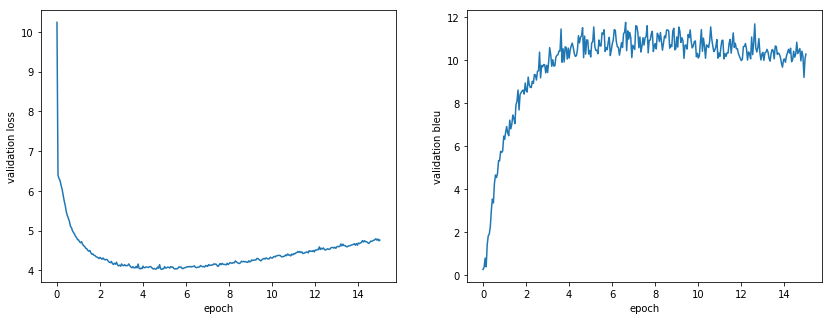

In [9]:
plot_single_learning_curve(load_experiment_log(experiment_name=MODEL_NAME)[0]['results'])

In [10]:
summarize_results(load_experiment_log(experiment_name=MODEL_NAME))[[
    'model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 'dt_created', 
    'num_layers', 'enc_hidden_dim', 'dec_hidden_dim']]

,model_name,best_val_loss,best_val_bleu,runtime,dt_created,num_layers,enc_hidden_dim,dec_hidden_dim
0,vi-rnn-additive-attn,4.024504,0.267568,784.446536,2018-12-09 21:04:07,2,512,1024


In [ ]:
# reload model and test 
encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

# # without attention 
# decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
#                      targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                      pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)

# with additive attention 
decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                         num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id'])

# # with multiplicative attention 
# decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
#                          num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [ ]:
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME), map_location=device)
model.load_state_dict(checkpoint)